In [144]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

import pickle

In [733]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_roc_curve, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import VotingClassifier

from sklearn.inspection import permutation_importance

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [147]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Useful Functions

In [148]:
def auc_proba_scorer(model, X, y):
    y_pred = model.predict_proba(X)[:,1]
    return roc_auc_score(y, y_pred)

In [149]:
def cv_aurocs(x, y, model, cv):
    scores = cross_val_score(model, x, y, scoring=auc_proba_scorer, cv=cv)
    scores = [round(val, 3) for val in scores]
    
    print('\nCV AUROCs: {}'.format(scores)) 
    print('Mean CV AUROC: {} +/- {}'.format(round(np.mean(scores), 3), round(np.std(scores), 3)))

In [303]:
def plot_prec_recall(y_1, y_1_pred, y_2=None, y_2_pred=None, single_title=None, single=False, test=False):
    precisions1, recalls1, threshs1 = precision_recall_curve(y_1, y_1_pred )
    if single:
        N = 1
    else:
        N = 2
        precisions2, recalls2, threshs2 = precision_recall_curve(y_2, y_2_pred )
    
    plt.figure(figsize=(8*N,10), dpi=80)
    plt.subplot(2, N, 1)
    plt.plot(threshs1, precisions1[1:], label='Precision', lw=3)
    plt.plot(threshs1, recalls1[1:], label='Recall', lw=3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xticks(np.linspace(0,1,11))
    plt.yticks(np.linspace(0,1,11))
    plt.grid(b=True)
    plt.legend(prop={"size":12})
    plt.xlabel('Threshold', size=13)
    if single_title == None:
        plt.title('Training Set', size=20)
    else:
        plt.title(single_title, size=20)
    plt.xticks(size=12)
    plt.yticks(size=12)
    
    if N == 2:
        plt.subplot(2, N, 2)
        plt.plot(threshs2, precisions2[1:], label='Precision', lw=3)
        plt.plot(threshs2, recalls2[1:], label='Recall', lw=3)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xticks(np.linspace(0,1,11))
        plt.yticks(np.linspace(0,1,11))
        plt.grid(b=True)
        plt.legend(prop={"size":12})
        plt.xlabel('Threshold', size=13)
        if test:
            plt.title('Test Set', size=20)
        else:
            plt.title('Validation Set', size=20)
        plt.xticks(size=12)
        plt.yticks(size=12)
    
    plt.subplot(2, N, N+1)
    plt.plot(recalls1[1:], precisions1[1:], lw=3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xticks(np.linspace(0,1,11))
    plt.yticks(np.linspace(0,1,11))
    plt.grid(b=True)
    plt.xlabel("Recall", size=16)
    plt.ylabel("Precision", size=16)
    plt.xticks(size=12)
    plt.yticks(size=12)
    
    if N == 2:
        plt.subplot(2, N, 4)
        plt.plot(recalls2[1:], precisions2[1:], lw=3)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xticks(np.linspace(0,1,11))
        plt.yticks(np.linspace(0,1,11))
        plt.grid(b=True)
        plt.xlabel("Recall", size=16)
        plt.ylabel("Precision", size=16)
        plt.xticks(size=12)
        plt.yticks(size=12);

In [836]:
def plot_aurocs(y_1, y_1_pred, y_2=None, y_2_pred=None, single_title=None, single=False, test=False):
    fpr1, tpr1, thresholds1 = roc_curve(y_1, y_1_pred)
    roc_auc1 = roc_auc_score(y_1, y_1_pred)
    if not single:
        fpr2, tpr2, thresholds2 = roc_curve(y_2, y_2_pred)
        roc_auc2 = roc_auc_score(y_2, y_2_pred)
    
    plt.figure(figsize=(10,10), dpi=80)
    if single_title != None:
        plt.plot(fpr1, tpr1, lw=3, label=single_title + '(AUC = %0.3f)' % roc_auc1)
    else:
        plt.plot(fpr1, tpr1, lw=3, label='Training Set (AUC = %0.3f)' % roc_auc1)
    if not single:
        if test:
            plt.plot(fpr2, tpr2, lw=3, label='Test Set (AUC = %0.3f)' % roc_auc2)
        else:
            plt.plot(fpr2, tpr2, lw=3, label='Validation Set (AUC = %0.3f)' % roc_auc2)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xticks(np.linspace(0,1,11))
    plt.yticks(np.linspace(0,1,11))
    plt.grid(b=True)
    plt.title('AUROC', size=26)
    plt.legend(prop={"size":12})
    plt.xlabel('False Positive Rate', size=20)
    plt.ylabel('True Positive Rate', size=20)
    plt.xticks(size=16)
    plt.yticks(size=16);

## 1) Read in the dataset Train/Val/Test data & targets
#### (Previously created, including engineered features and without dropping 1st col of 1-hots, in Logistic Regression worksheet)

In [152]:
X_train = pd.read_csv('dataset_with_new_features_train_randomState42.csv', index_col=0)
print(X_train.shape)
X_train.head()

(16971, 71)


age  gender  asa_status    bmi  baseline_cancer  baseline_cvd  \
29384  74.8     1.0         2.0  31.73                1             1   
9519   35.1     0.0         1.0  22.56                1             0   
9928   78.9     1.0         2.0  20.62                0             1   
22483  68.1     1.0         2.0  32.16                1             1   
29900  64.3     0.0         1.0  25.45                1             0   

       baseline_dementia  baseline_diabetes  baseline_digestive  \
29384                  0                  0                   0   
9519                   0                  0                   0   
9928                   0                  0                   0   
22483                  0                  1                   0   
29900                  0                  0                   0   

       baseline_osteoart  baseline_psych  baseline_pulmonary  \
29384                  0               0                   0   
9519                   0               0                   0   
9928                   1               0                   0   
22483                  0               0                   0   
29900                  0               0                   0   

       baseline_charlson  mortality_rsi  complication_rsi  ccsMort30Rate  \
29384                  0          -0.45             -1.35       0.007424   
9519                   6           3.65              2.91       0.007398   
9928                   1          -0.20              0.26       0.007398   
22483                  3          -0.86             -0.76       0.000373   
29900                  2           0.00              0.00       0.000672   

       ccsComplicationRate  race_1.0  race_2.0  race_3.0  ahrq_ccs_<Other>  \
29384             0.183370         1         0         0                 0   
9519              0.097476         1         0         0                 0   
9928              0.097476         1         0         0                 0   
22483             0.109369         1         0         0                 0   
29900             0.016118         0         0         1                 0   

       ahrq_ccs_Arthroplasty knee  ahrq_ccs_Colorectal resection  \
29384                           0                              0   
9519                            0                              0   
9928                            0                              0   
22483                           0                              0   
29900                           0                              0   

       ahrq_ccs_Endoscopy and endoscopic biopsy of the urinary tract  \
29384                                                  0               
9519                                                   0               
9928                                                   0               
22483                                                  0               
29900                                                  0               

       ahrq_ccs_Gastrectomy; partial and total  \
29384                                        0   
9519                                         0   
9928                                         0   
22483                                        0   
29900                                        0   

       ahrq_ccs_Genitourinary incontinence procedures  \
29384                                               0   
9519                                                0   
9928                                                0   
22483                                               0   
29900                                               0   

       ahrq_ccs_Hip replacement; total and partial  \
29384                                            0   
9519                                             1   
9928                                             1   
22483                                            0   
29900                                            0   

       ahrq_ccs_Hysterectomy; abdominal and 

In [153]:
y_train = pd.read_csv('target_train_randomState42.csv', index_col=0)
print(y_train.shape)
y_train.head()

(16971, 2)


mort30  complication
29384       0             0
9519        0             0
9928        0             1
22483       0             0
29900       0             0

In [154]:
X_val = pd.read_csv('dataset_with_new_features_val_randomState42.csv', index_col=0)
print(X_val.shape)
X_val.head()

(5658, 71)


age  gender  asa_status    bmi  baseline_cancer  baseline_cvd  \
15110  78.1     1.0         2.0  24.82                0             1   
27752  69.2     0.0         2.0  36.10                0             1   
22388  71.0     1.0         2.0  22.05                1             1   
28742  71.7     0.0         1.0  28.71                1             0   
9326   61.9     0.0         2.0  20.60                0             1   

       baseline_dementia  baseline_diabetes  baseline_digestive  \
15110                  0                  0                   0   
27752                  0                  1                   0   
22388                  0                  0                   0   
28742                  0                  0                   1   
9326                   0                  0                   0   

       baseline_osteoart  baseline_psych  baseline_pulmonary  \
15110                  0               0                   0   
27752                  0               0                   0   
22388                  0               0                   0   
28742                  0               1                   0   
9326                   1               0                   1   

       baseline_charlson  mortality_rsi  complication_rsi  ccsMort30Rate  \
15110                  1          -0.77             -1.75       0.000789   
27752                  1          -0.57             -0.83       0.007424   
22388                  2          -1.30             -0.83       0.000373   
28742                  0          -0.06              0.70       0.007424   
9326                   1          -1.03             -0.16       0.007398   

       ccsComplicationRate  race_1.0  race_2.0  race_3.0  ahrq_ccs_<Other>  \
15110             0.105720         1         0         0                 0   
27752             0.183370         1         0         0                 0   
22388             0.109369         0         0         1                 0   
28742             0.183370         1         0         0                 0   
9326              0.097476         1         0         0                 0   

       ahrq_ccs_Arthroplasty knee  ahrq_ccs_Colorectal resection  \
15110                           0                              0   
27752                           0                              0   
22388                           0                              0   
28742                           0                              0   
9326                            0                              0   

       ahrq_ccs_Endoscopy and endoscopic biopsy of the urinary tract  \
15110                                                  0               
27752                                                  0               
22388                                                  0               
28742                                                  0               
9326                                                   0               

       ahrq_ccs_Gastrectomy; partial and total  \
15110                                        0   
27752                                        0   
22388                                        0   
28742                                        0   
9326                                         0   

       ahrq_ccs_Genitourinary incontinence procedures  \
15110                                               0   
27752                                               0   
22388                                               0   
28742                                               0   
9326                                                0   

       ahrq_ccs_Hip replacement; total and partial  \
15110                                            0   
27752                                            0   
22388                                            0   
28742                                            0   
9326                                             1   

       ahrq_ccs_Hysterectomy; abdominal and 

In [155]:
y_val = pd.read_csv('target_val_randomState42.csv', index_col=0)
print(y_val.shape)
y_val.head()

(5658, 2)


mort30  complication
15110       0             0
27752       0             1
22388       0             0
28742       0             0
9326        0             0

In [156]:
X_test = pd.read_csv('dataset_with_new_features_test_randomState42.csv', index_col=0)
print(X_test.shape)
X_test.head()

(5658, 71)


age  gender  asa_status    bmi  baseline_cancer  baseline_cvd  \
13878  57.1     1.0         1.0  31.51                0             0   
28195  46.0     1.0         1.0  27.12                0             0   
22111  60.4     1.0         1.0  28.75                1             1   
29383  38.8     0.0         1.0  34.48                0             0   
20936  50.6     1.0         1.0  29.97                1             0   

       baseline_dementia  baseline_diabetes  baseline_digestive  \
13878                  0                  0                   0   
28195                  0                  0                   0   
22111                  0                  0                   1   
29383                  0                  0                   0   
20936                  0                  0                   0   

       baseline_osteoart  baseline_psych  baseline_pulmonary  \
13878                  0               0                   0   
28195                  0               0                   0   
22111                  0               0                   0   
29383                  0               0                   0   
20936                  0               0                   1   

       baseline_charlson  mortality_rsi  complication_rsi  ccsMort30Rate  \
13878                  0          -0.43             -1.65       0.000789   
28195                  0          -1.33              0.00       0.007424   
22111                  2          -0.86             -0.26       0.000373   
29383                  0           0.00              0.00       0.007424   
20936                  9           1.05              0.57       0.000373   

       ccsComplicationRate  race_1.0  race_2.0  race_3.0  ahrq_ccs_<Other>  \
13878             0.105720         1         0         0                 0   
28195             0.183370         1         0         0                 0   
22111             0.109369         1         0         0                 0   
29383             0.183370         1         0         0                 0   
20936             0.109369         1         0         0                 0   

       ahrq_ccs_Arthroplasty knee  ahrq_ccs_Colorectal resection  \
13878                           0                              0   
28195                           0                              0   
22111                           0                              0   
29383                           0                              0   
20936                           0                              0   

       ahrq_ccs_Endoscopy and endoscopic biopsy of the urinary tract  \
13878                                                  0               
28195                                                  0               
22111                                                  0               
29383                                                  0               
20936                                                  0               

       ahrq_ccs_Gastrectomy; partial and total  \
13878                                        0   
28195                                        0   
22111                                        0   
29383                                        0   
20936                                        0   

       ahrq_ccs_Genitourinary incontinence procedures  \
13878                                               0   
28195                                               0   
22111                                               0   
29383                                               0   
20936                                               0   

       ahrq_ccs_Hip replacement; total and partial  \
13878                                            0   
28195                                            0   
22111                                            0   
29383                                            0   
20936                                            0   

       ahrq_ccs_Hysterectomy; abdominal and 

In [157]:
y_test = pd.read_csv('target_test_randomState42.csv', index_col=0)
print(y_test.shape)
y_test.head()

(5658, 2)


mort30  complication
13878       0             0
28195       0             0
22111       0             0
29383       0             0
20936       0             0

#### Must get rid of ''<'' in the column names for XGBoost to work

In [158]:
X_train.rename(columns={'ahrq_ccs_<Other>': 'ahrq_css_other'}, inplace=True)
X_train.rename(columns={'ahrq_ccs_Transurethral resection of prostate (TURP)': 'ahrq_css_TURP'}, inplace=True)

X_val.rename(columns={'ahrq_ccs_<Other>': 'ahrq_css_other'}, inplace=True)
X_val.rename(columns={'ahrq_ccs_Transurethral resection of prostate (TURP)': 'ahrq_css_TURP'}, inplace=True)

X_test.rename(columns={'ahrq_ccs_<Other>': 'ahrq_css_other'}, inplace=True)
X_test.rename(columns={'ahrq_ccs_Transurethral resection of prostate (TURP)': 'ahrq_css_TURP'}, inplace=True)

#### Need to drop the first column of both one-hots

In [159]:
print(X_train.shape)
X_train_lr = X_train.drop(columns=['race_1.0', 'ahrq_css_other'])
print(X_train_lr.shape)

print('\n')

print(X_val.shape)
X_val_lr = X_val.drop(columns=['race_1.0', 'ahrq_css_other'])
print(X_val_lr.shape)

print('\n')

print(X_test.shape)
X_test_lr = X_test.drop(columns=['race_1.0', 'ahrq_css_other'])
print(X_test_lr.shape)

(16971, 71)
(16971, 69)


(5658, 71)
(5658, 69)


(5658, 71)
(5658, 69)


#### RandomForest & XGB silently convert floats to float32; max('age_exp') & max('bmi_exp') exceed max representable float32 value
#### SO: Will convert any value of 'age_exp' that exceeds the max representable float32 to that max representable value

In [160]:
max_float32 = np.finfo(np.float32).max
X_train['age_exp'] = X_train['age_exp'].apply(lambda x: x if x <= max_float32 else max_float32)
X_train['bmi_exp'] = X_train['bmi_exp'].apply(lambda x: x if x <= max_float32 else max_float32)

X_val['age_exp'] = X_val['age_exp'].apply(lambda x: x if x <= max_float32 else max_float32)
X_val['bmi_exp'] = X_val['bmi_exp'].apply(lambda x: x if x <= max_float32 else max_float32)

X_test['age_exp'] = X_test['age_exp'].apply(lambda x: x if x <= max_float32 else max_float32)
X_test['bmi_exp'] = X_test['bmi_exp'].apply(lambda x: x if x <= max_float32 else max_float32)

## 2) Scale the data for Logisitic Regression

In [161]:
scaled_cols = [val[0] for val in pd.read_csv('scaled_cols.csv', index_col=0).values]

In [162]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lr[scaled_cols])
X_train_scaled = np.concatenate([X_train_scaled,
                                 X_train_lr.drop(columns=scaled_cols)], axis=1)

del X_train_lr
print('X_train_scaled shape: {}'.format(X_train_scaled.shape))

X_train_scaled shape: (16971, 69)


In [163]:
X_val_scaled = scaler.fit_transform(X_val_lr[scaled_cols])
X_val_scaled = np.concatenate([X_val_scaled,
                               X_val_lr.drop(columns=scaled_cols)], axis=1)

del X_val_lr
print('X_val_scaled shape: {}'.format(X_val_scaled.shape))

X_val_scaled shape: (5658, 69)


In [164]:
X_test_scaled = scaler.fit_transform(X_test_lr[scaled_cols])
X_test_scaled = np.concatenate([X_test_scaled,
                                X_test_lr.drop(columns=scaled_cols)], axis=1)

del X_test_lr
print('X_test_scaled shape: {}'.format(X_test_scaled.shape))

X_test_scaled shape: (5658, 69)


## 4) Read in, train and score previously-built models

In [165]:
file_names = ['finalized_lr_mort_auc_opt.sav', 'finalized_lr_mort_logloss_opt.sav',
              'finalized_rf_mort_auc_opt.sav', 'finalized_rf_mort_logloss_opt.sav',
              'finalized_xgb_mort_auc_opt.sav', 'finalized_xgb_mort_logloss_opt.sav']

model_names = ['lr_mort_auc_opt', 'lr_mort_logloss_opt', 'rf_mort_auc_opt', 
               'rf_mort_logloss_opt', 'xgb_mort_auc_opt', 'xgb_mort_logloss_opt']

models = []
for n, filename in enumerate(file_names):
    model = pickle.load(open(filename, 'rb'))
    models.append( (model_names[n], model) )

In [166]:
y_val_preds = []

for model in models:
    if 'lr_' in model[0]:
        model[1].fit(X_train_scaled, y_train['mort30'])
        y_val_preds.append(model[1].predict_proba(X_val_scaled)[:,1])
    else:
        model[1].fit(X_train, y_train['mort30'])
        y_val_preds.append(model[1].predict_proba(X_val)[:,1])

[17:35:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:35:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [167]:
auc_scores = []
for n, name in enumerate(model_names):
    auc_scores.append(round(roc_auc_score(y_val['mort30'], y_val_preds[n]), 3))
    
scores_df = pd.DataFrame(data={'model': model_names, 'auroc_score': auc_scores})
scores_df

model  auroc_score
0       lr_mort_auc_opt        0.940
1   lr_mort_logloss_opt        0.947
2       rf_mort_auc_opt        0.930
3   rf_mort_logloss_opt        0.930
4      xgb_mort_auc_opt        0.932
5  xgb_mort_logloss_opt        0.933

## 5) Ensembling

#### Will have to reconvert the scaled data (numpy arrays) to dataframes to match the unscaled data (already in dataframes)
#### GENERAL APPROACH: Will create double-wide dataframe with columns of entire unscaled df next to entire scaled df
#### (With this double-wide dataframe, can use Pipeline to select which cols to fit w/ each model (Logistic Reg. vs. Trees))

In [168]:
## Creating dataframes for the scaled data

all_cols = scaled_cols + X_train.drop(columns=scaled_cols) \
                                .drop(columns=['race_1.0', 'ahrq_css_other']) \
                                .columns.tolist()

# Pre-pend 's_' to every column name so we'll know this is part of the scaled dataframe
all_cols = ['s_' + col for col in all_cols]

X_train_scaled = pd.DataFrame(data=X_train_scaled, columns=all_cols)
X_val_scaled = pd.DataFrame(data=X_val_scaled, columns=all_cols)
X_test_scaled = pd.DataFrame(data=X_test_scaled, columns=all_cols)

In [169]:
## Concatenating the scaled data to the existing unscaled dataframe

X_train_scaled.index = X_train.index
X_val_scaled.index = X_val.index
X_test_scaled.index = X_test.index

for col in X_train_scaled.columns:
    X_train[col] = X_train_scaled[col]

for col in X_val_scaled.columns:
    X_val[col] = X_val_scaled[col]

for col in X_test_scaled.columns:
    X_test[col] = X_test_scaled[col]

In [27]:
# Use the scaled dataset columns for the logistic regression models
pipe0 = make_pipeline(make_column_transformer(('passthrough', slice(71, 141))), models[0][1])

pipe1 = make_pipeline(make_column_transformer(('passthrough', slice(71, 141))), models[1][1])

# Use the unscaled dataset columns for the tree-based models
pipe2 = make_pipeline(make_column_transformer(('passthrough', slice(0, 71))), models[2][1])

pipe3 = make_pipeline(make_column_transformer(('passthrough', slice(0, 71))), models[3][1])

pipe4 = make_pipeline(make_column_transformer(('passthrough', slice(0, 71))), models[4][1])

pipe5 = make_pipeline(make_column_transformer(('passthrough', slice(0, 71))), models[5][1])

## 5.1) "Kitchen Sink" Ensemble (uses every model available)

In [61]:
estimator_list = [('estimator_0', pipe0),
                  ('estimator_1', pipe1),
                  ('estimator_2', pipe2),
                  ('estimator_3', pipe3),
                  ('estimator_4', pipe4),
                  ('estimator_5', pipe5)]

In [62]:
vc = VotingClassifier(estimators=estimator_list, voting='soft', weights=None)

In [63]:
vc.fit(X_train, y_train['mort30'])

[16:48:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('estimator_0',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('passthrough',
                                                                                'passthrough',
                                                                                slice(71, 141, None))])),
                                              ('pipeline',
                                               Pipeline(steps=[('smote',
                                                                SMOTE(random_state=42,
                                                                      sampling_strategy=1.0)),
                                                               ('logisticregression',
                                                                LogisticRegression(C=5e-06,
                                                                                   l1_ratio=0,
    

In [64]:
y_train_preds_vc = vc.predict_proba(X_train)[:, 1]
y_val_preds_vc = vc.predict_proba(X_val)[:, 1]

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Training Set AUROC: 0.966446617698023
Validation Set AUROC: 0.9409359206820724






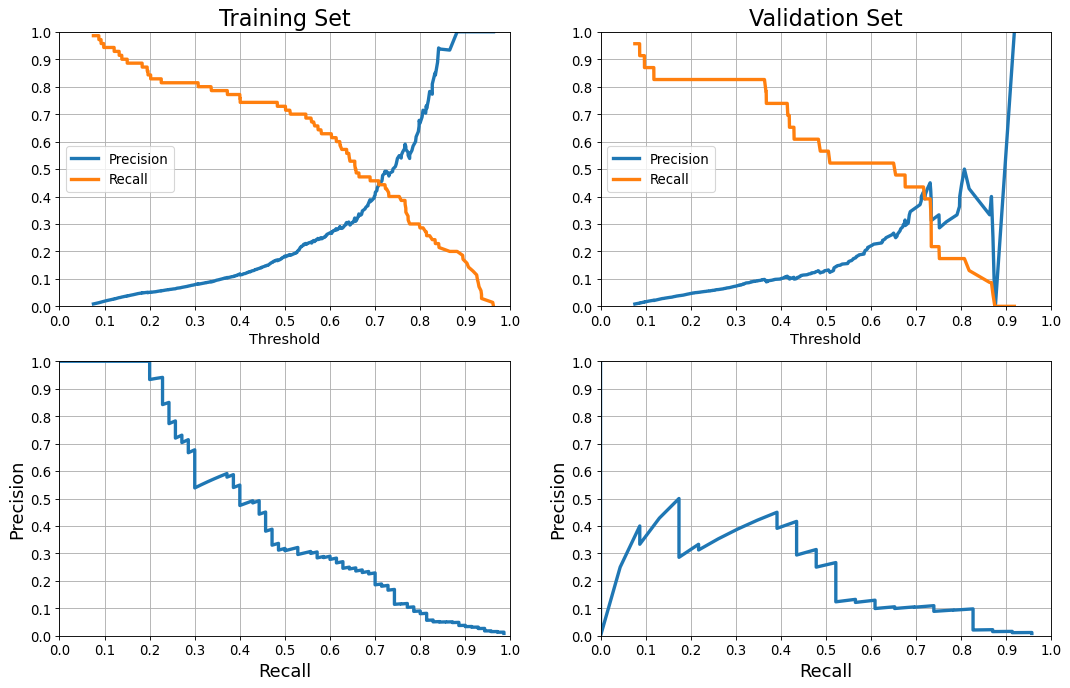

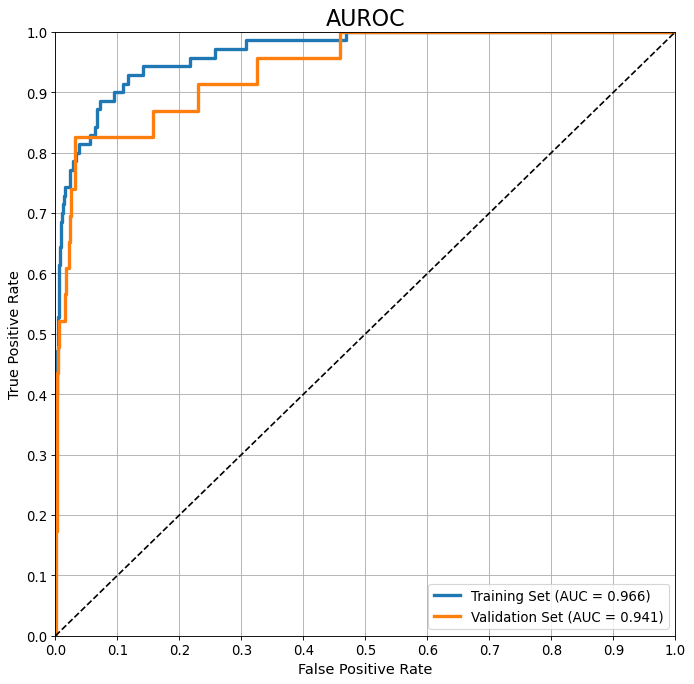

In [65]:
print('Training Set AUROC: {}'.format(roc_auc_score(y_train['mort30'], y_train_preds_vc)))
print('Validation Set AUROC: {}'.format(roc_auc_score(y_val['mort30'], y_val_preds_vc)))
print('\n')
plot_prec_recall(y_train['mort30'], y_train_preds_vc, y_val['mort30'], y_val_preds_vc)
print ('\n')
plot_aurocs(y_train['mort30'], y_train_preds_vc, y_val['mort30'], y_val_preds_vc)

In [66]:
fpr, tpr, thresholds = roc_curve(y_val['mort30'], y_val_preds_vc)
auc_data = pd.DataFrame(data={'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

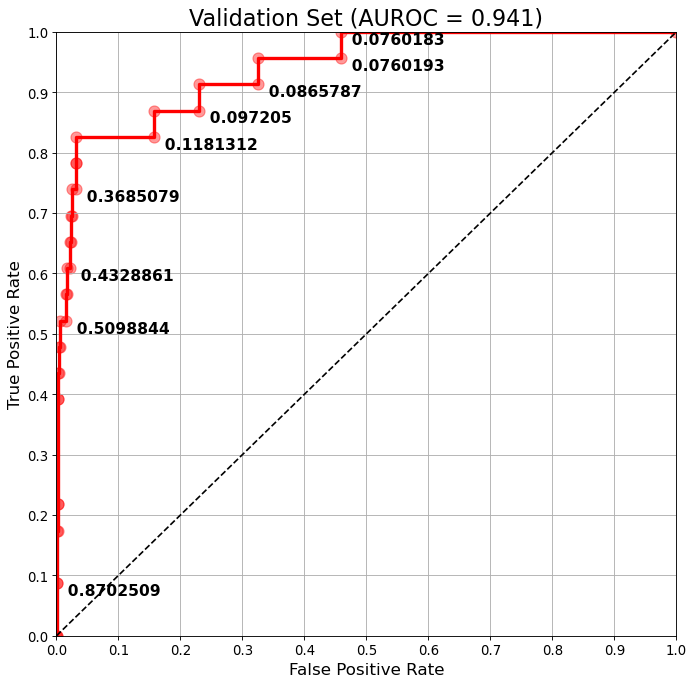

In [67]:
plt.figure(figsize=(10,10), dpi=80)
plt.plot(auc_data['fpr'], auc_data['tpr'], lw=3, color='red')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.scatter(auc_data['fpr'], auc_data['tpr'], s=100, color='red', alpha=0.4)

annotations = [str(round(thresh,7)) for thresh in thresholds]
annotations[0] = '1.0'
for i, label in enumerate(annotations):
    if i in [3, 16, 20, 26, 30, 32, 34, 36, 37]:
        plt.annotate('  ' + label, (auc_data['fpr'][i], auc_data['tpr'][i]),
                     horizontalalignment='left',
                     verticalalignment='top',
                     weight='bold', size=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.grid(b=True)
plt.title('Validation Set (AUROC = ' + str(round(roc_auc_score(y_val['mort30'], y_val_preds_vc), 3)) + ')', 
          size=20)
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.xticks(size=12)
plt.yticks(size=12);

In [68]:
df_val_preds = pd.DataFrame(data=y_val['mort30'].values, columns=['true'])
df_val_preds['pred'] = y_val_preds_vc

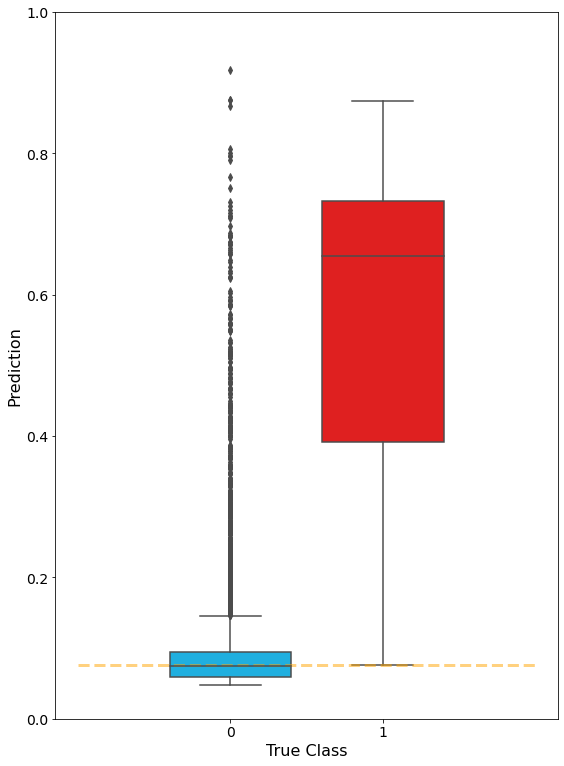

In [69]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_val_preds['true'].unique()}

plt.figure(figsize=(9,13))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.boxplot(data=df_val_preds, x='true', y='pred', palette=my_pal)
plt.plot([-1, 2], [0.0760183, 0.0760183], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

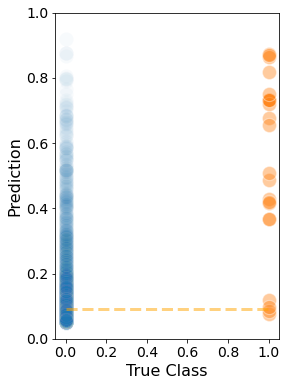

In [70]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_val_preds['true'].unique()}

plt.figure(figsize=(4,6))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.scatterplot(data=df_val_preds[df_val_preds['true'] == 0], x='true', y='pred', alpha=0.03, s=200)
sns.scatterplot(data=df_val_preds[df_val_preds['true'] == 1], x='true', y='pred', alpha=0.4, s=200)
plt.plot([-0, 1], [0.0911575, 0.0911575], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

In [71]:
thresh = 0.0760182

preds = df_val_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_val_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_val_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_val_preds['true'], preds), 3)))

[[3052 2583]
 [   0   23]]

Recall (TPR): 1.0

FPR: 0.458

Precision: 0.009


In [72]:
thresh = 0.1

preds = df_val_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_val_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_val_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_val_preds['true'], preds), 3)))

[[4444 1191]
 [   3   20]]

Recall (TPR): 0.87

FPR: 0.211

Precision: 0.017


## 5.2) "One of Each Model Type" Ensemble (the logloss-trained models)

In [73]:
estimator_list2 = [('estimator_1', pipe1),
                   ('estimator_3', pipe3),
                   ('estimator_5', pipe5)]

In [74]:
vc2 = VotingClassifier(estimators=estimator_list2, voting='soft', weights=None)

In [75]:
vc2.fit(X_train, y_train['mort30'])

[16:49:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('estimator_1',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('passthrough',
                                                                                'passthrough',
                                                                                slice(71, 141, None))])),
                                              ('logisticregression',
                                               LogisticRegression(C=0.15,
                                                                  class_weight={0: 1,
                                                                                1: 10},
                                                                  l1_ratio=1,
                                                                  max_iter=10000,
                                                                  penalty='elasticnet',
                          

In [83]:
y_train_preds_vc = vc2.predict_proba(X_train)[:, 1]
y_val_preds_vc = vc2.predict_proba(X_val)[:, 1]

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Training Set AUROC: 0.969591824659572
Validation Set AUROC: 0.9396319586435709






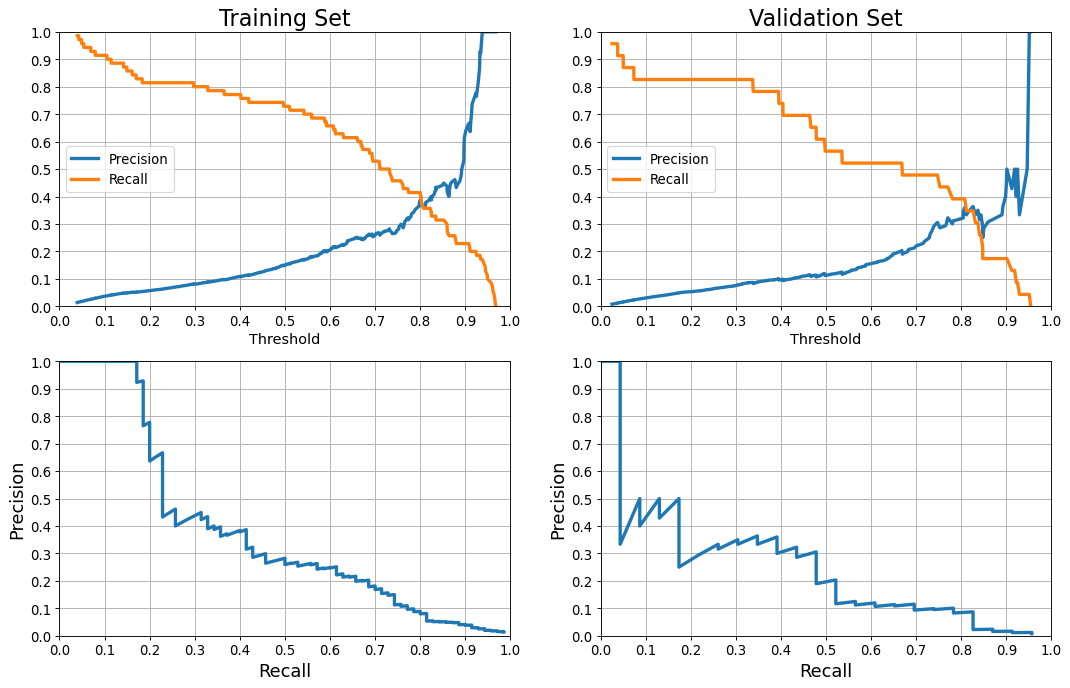

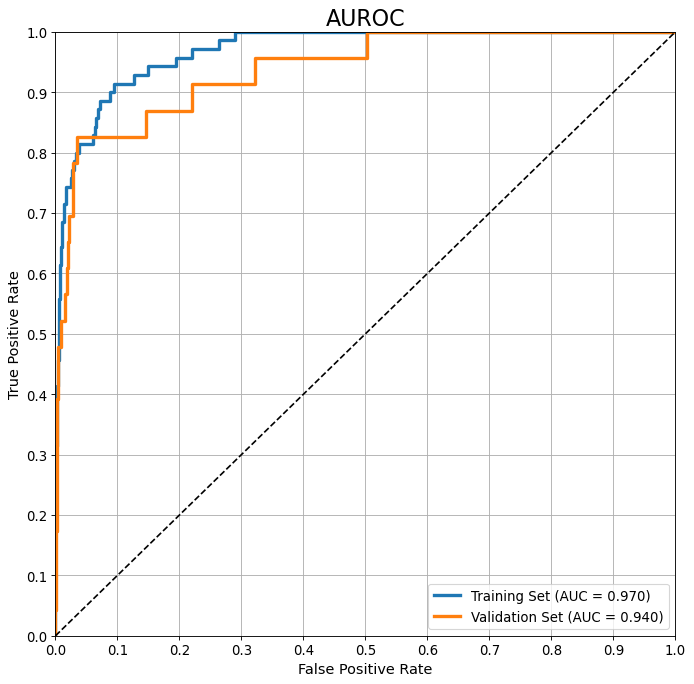

In [84]:
print('Training Set AUROC: {}'.format(roc_auc_score(y_train['mort30'], y_train_preds_vc)))
print('Validation Set AUROC: {}'.format(roc_auc_score(y_val['mort30'], y_val_preds_vc)))
print('\n')
plot_prec_recall(y_train['mort30'], y_train_preds_vc, y_val['mort30'], y_val_preds_vc)
print ('\n')
plot_aurocs(y_train['mort30'], y_train_preds_vc, y_val['mort30'], y_val_preds_vc)

In [85]:
fpr, tpr, thresholds = roc_curve(y_val['mort30'], y_val_preds_vc)
auc_data = pd.DataFrame(data={'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

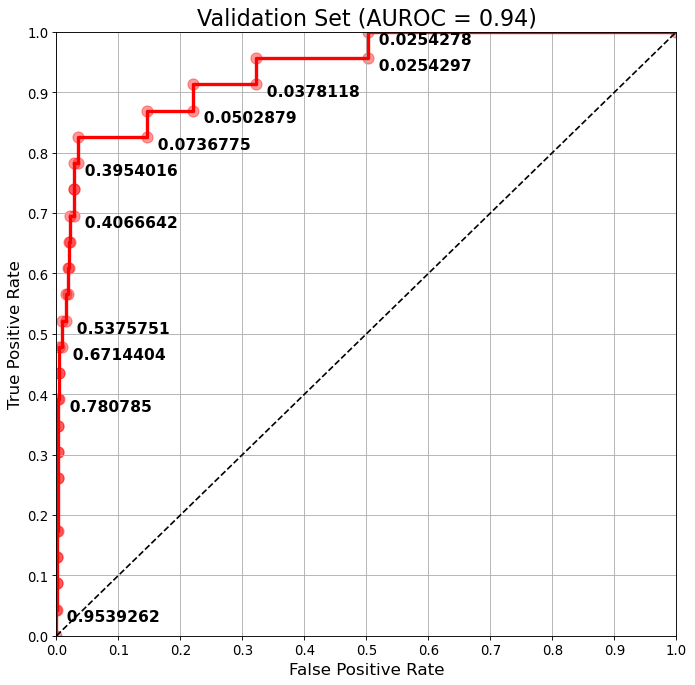

In [101]:
plt.figure(figsize=(10,10), dpi=80)
plt.plot(auc_data['fpr'], auc_data['tpr'], lw=3, color='red')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.scatter(auc_data['fpr'], auc_data['tpr'], s=100, color='red', alpha=0.4)

annotations = [str(round(thresh,7)) for thresh in thresholds]
annotations[0] = '1.0'
for i, label in enumerate(annotations):
    if i in [1, 16, 20, 22, 30, 33, 36, 38, 40, 42, 43]:
        plt.annotate('  ' + label, (auc_data['fpr'][i], auc_data['tpr'][i]),
                     horizontalalignment='left',
                     verticalalignment='top',
                     weight='bold', size=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.grid(b=True)
plt.title('Validation Set (AUROC = ' + str(round(roc_auc_score(y_val['mort30'], y_val_preds_vc), 3)) + ')', 
          size=20)
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.xticks(size=12)
plt.yticks(size=12);

In [87]:
df_val_preds = pd.DataFrame(data=y_val['mort30'].values, columns=['true'])
df_val_preds['pred'] = y_val_preds_vc

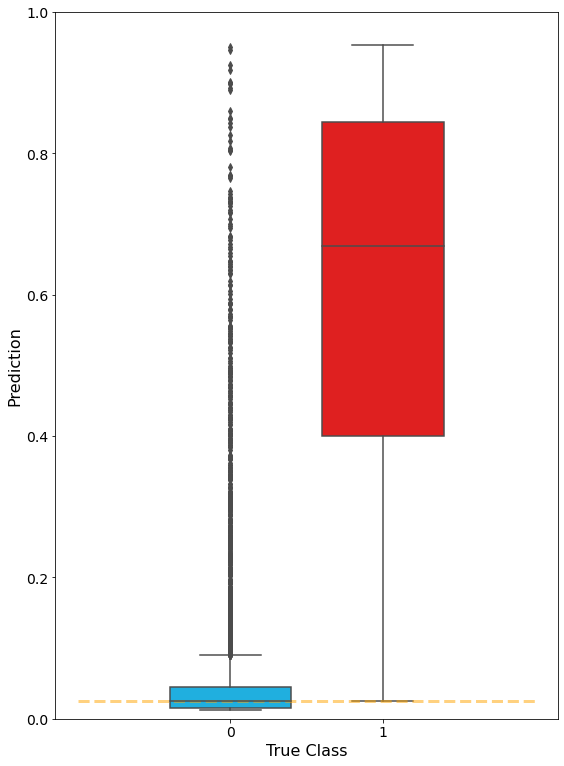

In [102]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_val_preds['true'].unique()}

plt.figure(figsize=(9,13))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.boxplot(data=df_val_preds, x='true', y='pred', palette=my_pal)
plt.plot([-1, 2], [0.0254278, 0.0254278], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

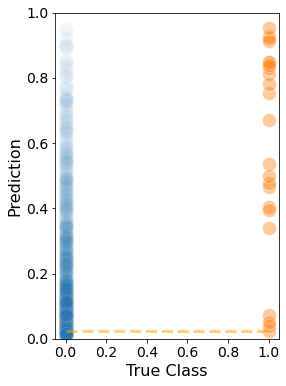

In [103]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_val_preds['true'].unique()}

plt.figure(figsize=(4,6))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.scatterplot(data=df_val_preds[df_val_preds['true'] == 0], x='true', y='pred', alpha=0.03, s=200)
sns.scatterplot(data=df_val_preds[df_val_preds['true'] == 1], x='true', y='pred', alpha=0.4, s=200)
plt.plot([-0, 1], [0.0254278, 0.0254278], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

In [104]:
thresh = 0.0254278

preds = df_val_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_val_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_val_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_val_preds['true'], preds), 3)))

[[2803 2832]
 [   0   23]]

Recall (TPR): 1.0

FPR: 0.503

Precision: 0.008


In [106]:
thresh = 0.0254279

preds = df_val_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_val_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_val_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_val_preds['true'], preds), 3)))

[[2803 2832]
 [   1   22]]

Recall (TPR): 0.957

FPR: 0.503

Precision: 0.008


## 5.3) "Logistic Regressions-only" Ensemble

In [78]:
estimator_list3 = [('estimator_1', pipe1),
                   ('estimator_2', pipe2)]

In [79]:
vc3 = VotingClassifier(estimators=estimator_list3, voting='soft', weights=None)

In [80]:
vc3.fit(X_train, y_train['mort30'])

VotingClassifier(estimators=[('estimator_1',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('passthrough',
                                                                                'passthrough',
                                                                                slice(71, 141, None))])),
                                              ('logisticregression',
                                               LogisticRegression(C=0.15,
                                                                  class_weight={0: 1,
                                                                                1: 10},
                                                                  l1_ratio=1,
                                                                  max_iter=10000,
                                                                  penalty='elasticnet',
                          

In [107]:
y_train_preds_vc = vc3.predict_proba(X_train)[:, 1]
y_val_preds_vc = vc3.predict_proba(X_val)[:, 1]

Training Set AUROC: 0.9664533797662014
Validation Set AUROC: 0.9406350063654951






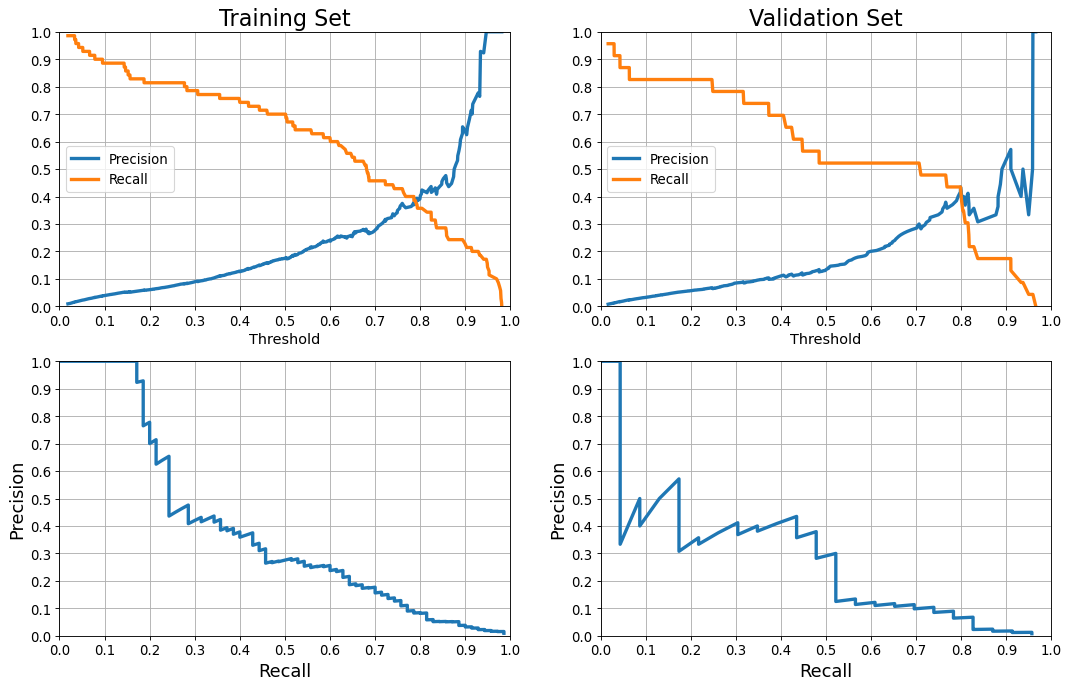

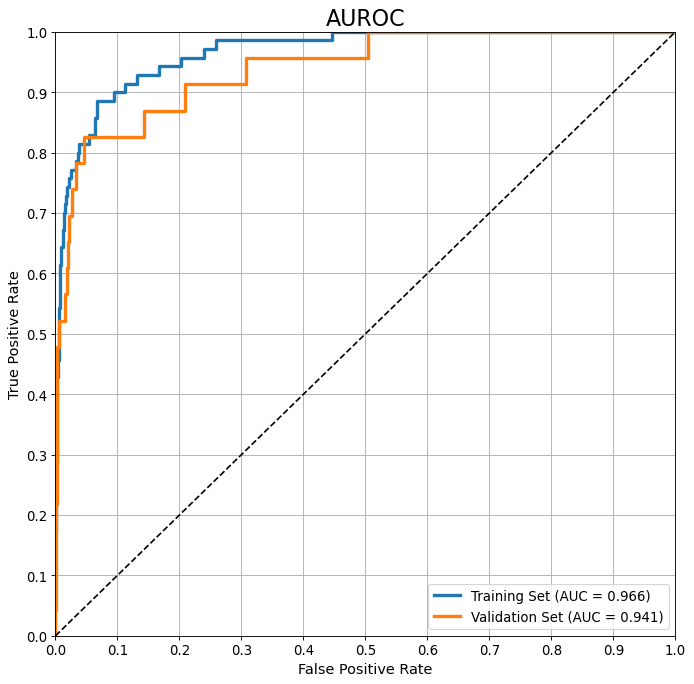

In [108]:
print('Training Set AUROC: {}'.format(roc_auc_score(y_train['mort30'], y_train_preds_vc)))
print('Validation Set AUROC: {}'.format(roc_auc_score(y_val['mort30'], y_val_preds_vc)))
print('\n')
plot_prec_recall(y_train['mort30'], y_train_preds_vc, y_val['mort30'], y_val_preds_vc)
print ('\n')
plot_aurocs(y_train['mort30'], y_train_preds_vc, y_val['mort30'], y_val_preds_vc)

In [109]:
fpr, tpr, thresholds = roc_curve(y_val['mort30'], y_val_preds_vc)
auc_data = pd.DataFrame(data={'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

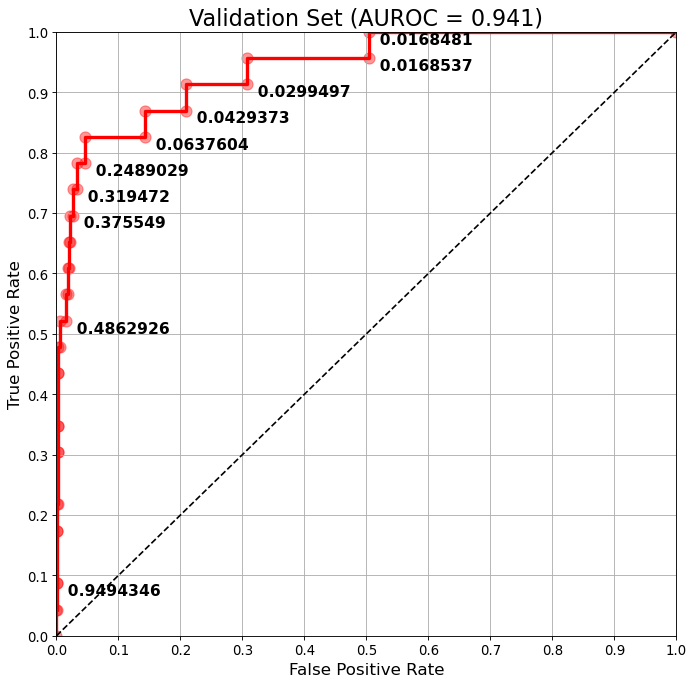

In [116]:
plt.figure(figsize=(10,10), dpi=80)
plt.plot(auc_data['fpr'], auc_data['tpr'], lw=3, color='red')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.scatter(auc_data['fpr'], auc_data['tpr'], s=100, color='red', alpha=0.4)

annotations = [str(round(thresh,7)) for thresh in thresholds]
annotations[0] = '1.0'
for i, label in enumerate(annotations):
    if i in [3, 18, 26, 28, 30, 32, 34, 36, 38, 39]:
        plt.annotate('  ' + label, (auc_data['fpr'][i], auc_data['tpr'][i]),
                     horizontalalignment='left',
                     verticalalignment='top',
                     weight='bold', size=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.grid(b=True)
plt.title('Validation Set (AUROC = ' + str(round(roc_auc_score(y_val['mort30'], y_val_preds_vc), 3)) + ')', 
          size=20)
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.xticks(size=12)
plt.yticks(size=12);

In [117]:
df_val_preds = pd.DataFrame(data=y_val['mort30'].values, columns=['true'])
df_val_preds['pred'] = y_val_preds_vc

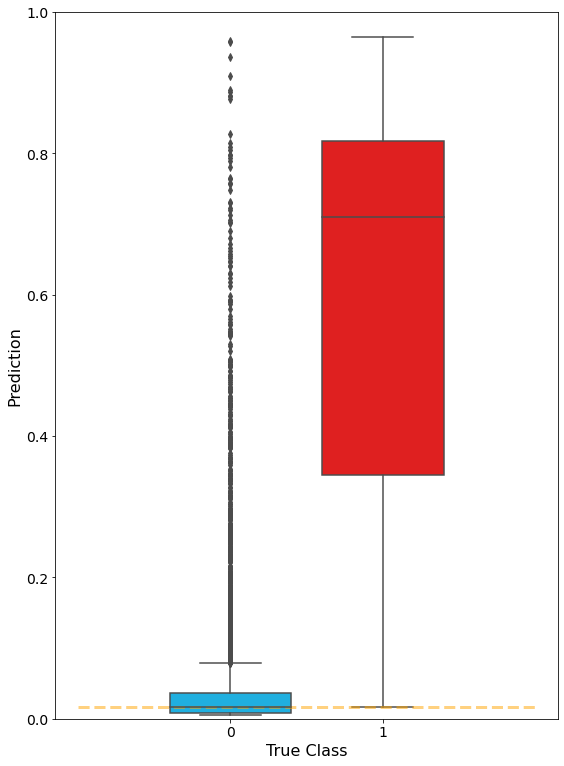

In [118]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_val_preds['true'].unique()}

plt.figure(figsize=(9,13))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.boxplot(data=df_val_preds, x='true', y='pred', palette=my_pal)
plt.plot([-1, 2], [0.0168481, 0.0168481], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

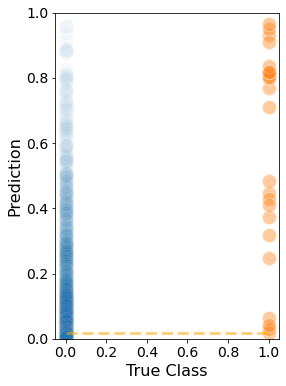

In [119]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_val_preds['true'].unique()}

plt.figure(figsize=(4,6))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.scatterplot(data=df_val_preds[df_val_preds['true'] == 0], x='true', y='pred', alpha=0.03, s=200)
sns.scatterplot(data=df_val_preds[df_val_preds['true'] == 1], x='true', y='pred', alpha=0.4, s=200)
plt.plot([-0, 1], [0.0168481, 0.0168481], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

In [120]:
thresh = 0.0168481

preds = df_val_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_val_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_val_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_val_preds['true'], preds), 3)))

[[2799 2836]
 [   0   23]]

Recall (TPR): 1.0

FPR: 0.503

Precision: 0.008


In [121]:
thresh = 0.0168482

preds = df_val_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_val_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_val_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_val_preds['true'], preds), 3)))

[[2799 2836]
 [   1   22]]

Recall (TPR): 0.957

FPR: 0.503

Precision: 0.008


## 6) Test Set Results: All Models

#### Combine Train and Val sets and retrain the models on this combined dataset

In [179]:
X_tr = X_train.append(X_val)

In [180]:
y_tr = y_train.append(y_val)

In [188]:
X_test.shape

(5658, 140)

### 6.1) Logistic Regression (hyper-parameter tuned on AUC metric)

In [837]:
models[0][1]

Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=1.0)),
                ('logisticregression',
                 LogisticRegression(C=5e-06, l1_ratio=0, max_iter=10000,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga'))])

In [186]:
cv_aurocs(X_tr.iloc[:, 71:], y_tr['mort30'], models[0][1], 5)


CV AUROCs: [0.926, 0.945, 0.928, 0.957, 0.928]
Mean CV AUROC: 0.937 +/- 0.012


Training Set AUROC: 0.9438499356823585
Test Set AUROC: 0.9643015619453319






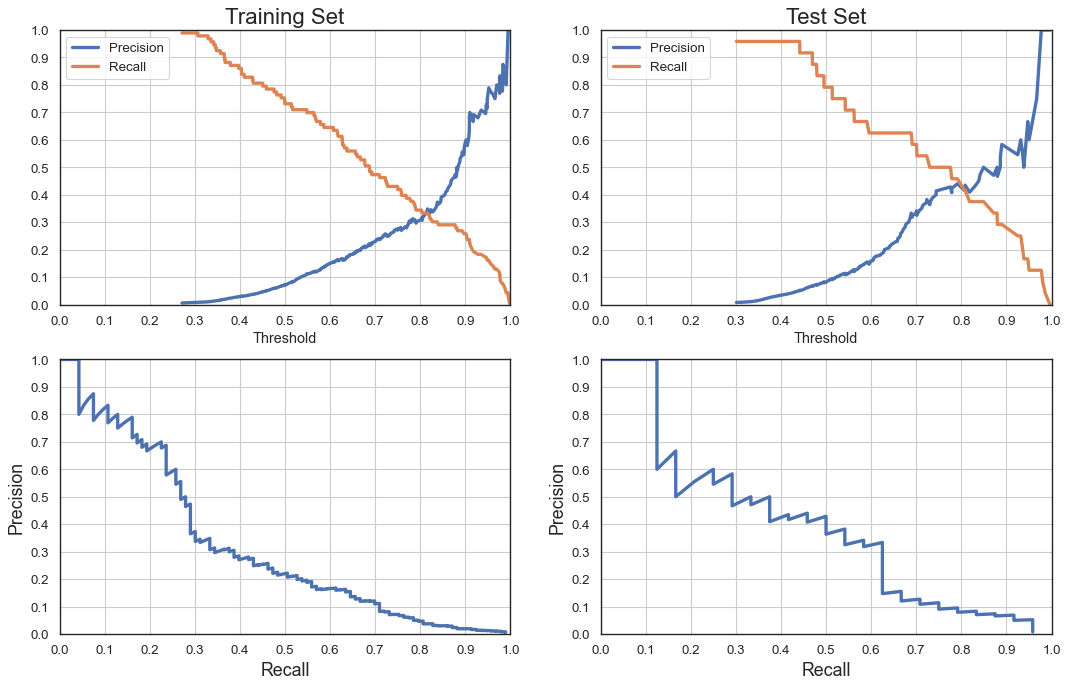

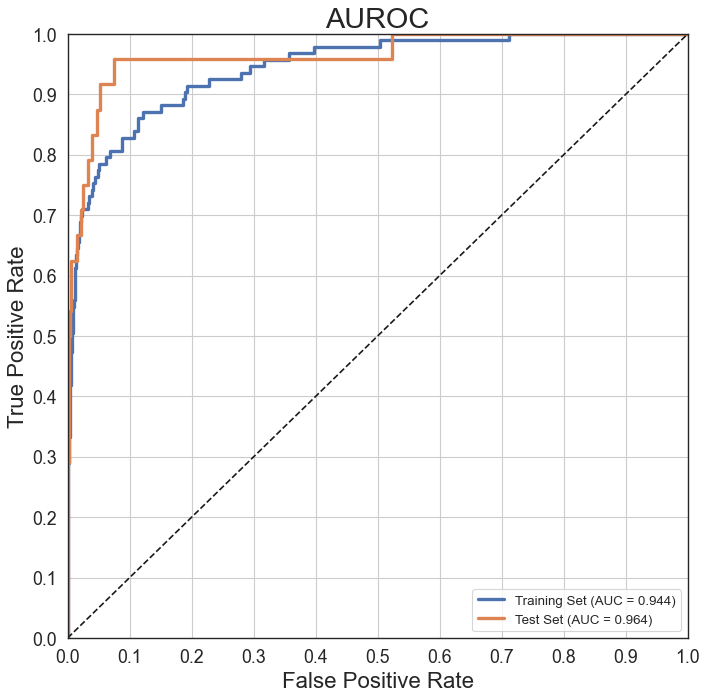

In [838]:
models[0][1].fit(X_tr.iloc[:, 71:], y_tr['mort30'])

y_tr_pred = models[0][1].predict_proba(X_tr.iloc[:, 71:])[:,1]

y_test_pred = models[0][1].predict_proba(X_test.iloc[:, 71:])[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_tr['mort30'], y_tr_pred)))
print('Test Set AUROC: {}'.format(roc_auc_score(y_test['mort30'], y_test_pred)))
print('\n')
plot_prec_recall(y_tr['mort30'], y_tr_pred, y_test['mort30'], y_test_pred, test=True)
print ('\n')
plot_aurocs(y_tr['mort30'], y_tr_pred, y_test['mort30'], y_test_pred, test=True)

In [839]:
fpr, tpr, thresholds = roc_curve(y_test['mort30'], y_test_pred)
auc_data = pd.DataFrame(data={'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

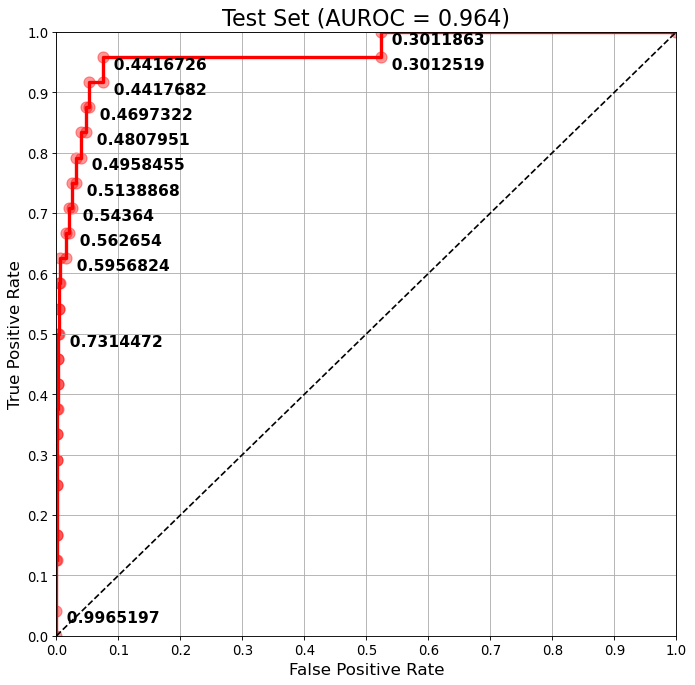

In [307]:
plt.figure(figsize=(10,10), dpi=80)
plt.plot(auc_data['fpr'], auc_data['tpr'], lw=3, color='red')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.scatter(auc_data['fpr'], auc_data['tpr'], s=100, color='red', alpha=0.4)

annotations = [str(round(thresh,7)) for thresh in thresholds]
annotations[0] = '1.0'
for i, label in enumerate(annotations):
    if i in [1, 19, 25, 27, 29, 31, 33, 35, 37, 39, 40, 41, 42]:
        plt.annotate('  ' + label, (auc_data['fpr'][i], auc_data['tpr'][i]),
                     horizontalalignment='left',
                     verticalalignment='top',
                     weight='bold', size=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.grid(b=True)
plt.title('Test Set (AUROC = ' + str(round(roc_auc_score(y_test['mort30'], y_test_pred), 3)) + ')', 
          size=20)
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.xticks(size=12)
plt.yticks(size=12);

In [308]:
df_test_preds = pd.DataFrame(data=y_test['mort30'].values, columns=['true'])
df_test_preds['pred'] = y_test_pred

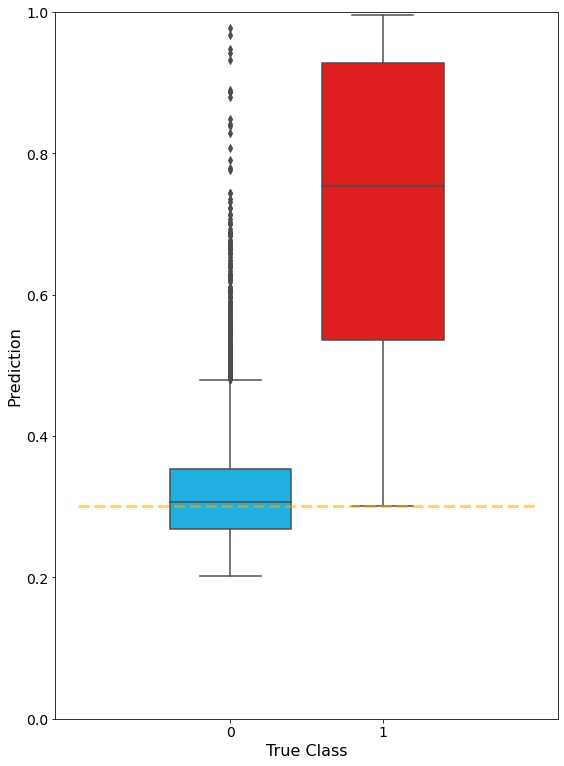

In [309]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

plt.figure(figsize=(9,13))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.boxplot(data=df_test_preds, x='true', y='pred', palette=my_pal)
plt.plot([-1, 2], [0.3011863, 0.3011863], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

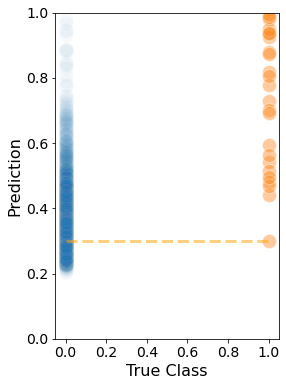

In [310]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

plt.figure(figsize=(4,6))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 0], x='true', y='pred', alpha=0.03, s=200)
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 1], x='true', y='pred', alpha=0.4, s=200)
plt.plot([-0, 1], [0.3011863, 0.3011863], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

In [311]:
thresh = 0.3011862

preds = df_test_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_test_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_test_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_test_preds['true'], preds), 3)))

[[2687 2947]
 [   0   24]]

Recall (TPR): 1.0

FPR: 0.523

Precision: 0.008


In [312]:
thresh = 0.4416726

preds = df_test_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_test_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_test_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_test_preds['true'], preds), 3)))

[[5215  419]
 [   1   23]]

Recall (TPR): 0.958

FPR: 0.074

Precision: 0.052


### 6.2) Logistic Regression (hyper-parameter tuned on log-loss metric)

In [190]:
models[1][1]

LogisticRegression(C=0.15, class_weight={0: 1, 1: 10}, l1_ratio=1,
                   max_iter=10000, penalty='elasticnet', random_state=42,
                   solver='saga')

In [191]:
cv_aurocs(X_tr.iloc[:, 71:], y_tr['mort30'], models[1][1], 5)


CV AUROCs: [0.863, 0.893, 0.916, 0.924, 0.932]
Mean CV AUROC: 0.906 +/- 0.025


Training Set AUROC: 0.9527990579469503
Test Set AUROC: 0.9639687610933617






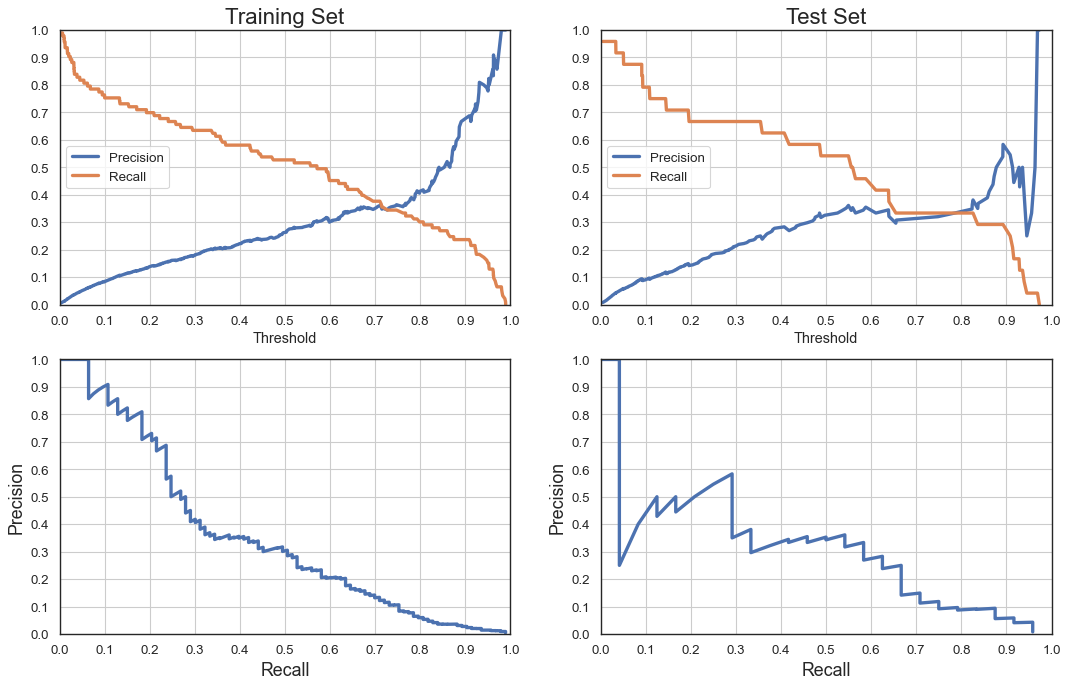

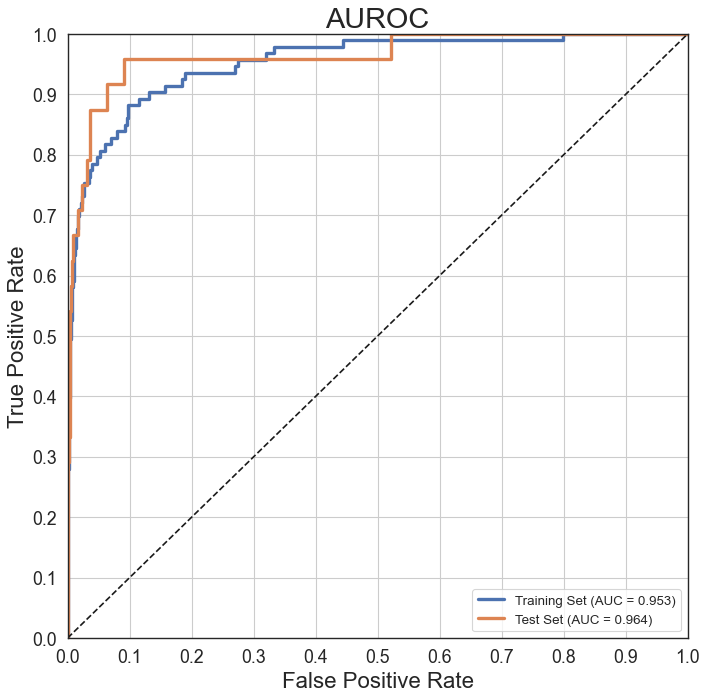

In [843]:
models[1][1].fit(X_tr.iloc[:, 71:], y_tr['mort30'])

y_tr_pred = models[1][1].predict_proba(X_tr.iloc[:, 71:])[:,1]

y_test_pred = models[1][1].predict_proba(X_test.iloc[:, 71:])[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_tr['mort30'], y_tr_pred)))
print('Test Set AUROC: {}'.format(roc_auc_score(y_test['mort30'], y_test_pred)))
print('\n')
plot_prec_recall(y_tr['mort30'], y_tr_pred, y_test['mort30'], y_test_pred, test=True)
print ('\n')
plot_aurocs(y_tr['mort30'], y_tr_pred, y_test['mort30'], y_test_pred, test=True)

In [844]:
fpr, tpr, thresholds = roc_curve(y_test['mort30'], y_test_pred)
auc_data = pd.DataFrame(data={'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

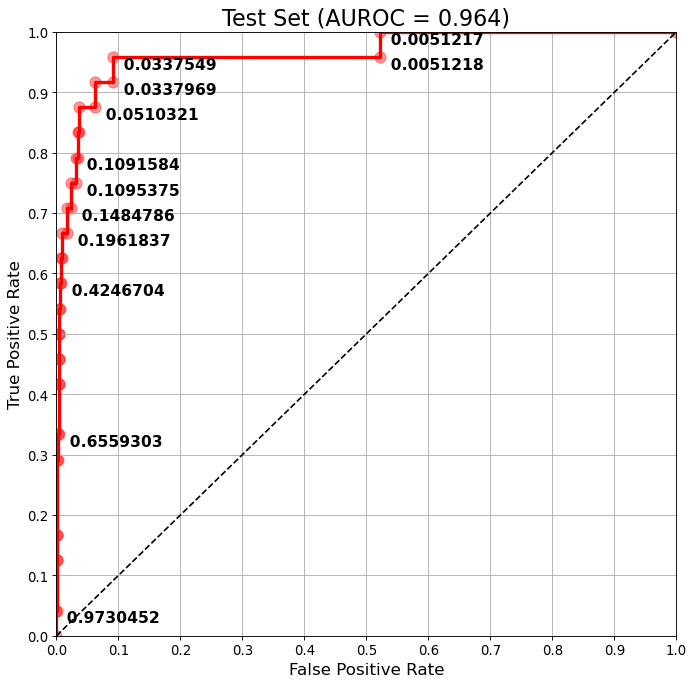

In [331]:
plt.figure(figsize=(10,10), dpi=80)
plt.plot(auc_data['fpr'], auc_data['tpr'], lw=3, color='red')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.scatter(auc_data['fpr'], auc_data['tpr'], s=100, color='red', alpha=0.4)

annotations = [str(round(thresh,7)) for thresh in thresholds]
annotations[0] = '1.0'
for i, label in enumerate(annotations):
    if i in [1, 10, 20, 24, 26, 28, 29, 34, 36, 37, 38, 39]:
        plt.annotate('  ' + label, (auc_data['fpr'][i], auc_data['tpr'][i]),
                     horizontalalignment='left',
                     verticalalignment='top',
                     weight='bold', size=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.grid(b=True)
plt.title('Test Set (AUROC = ' + str(round(roc_auc_score(y_test['mort30'], y_test_pred), 3)) + ')', 
          size=20)
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.xticks(size=12)
plt.yticks(size=12);

In [332]:
df_test_preds = pd.DataFrame(data=y_test['mort30'].values, columns=['true'])
df_test_preds['pred'] = y_test_pred

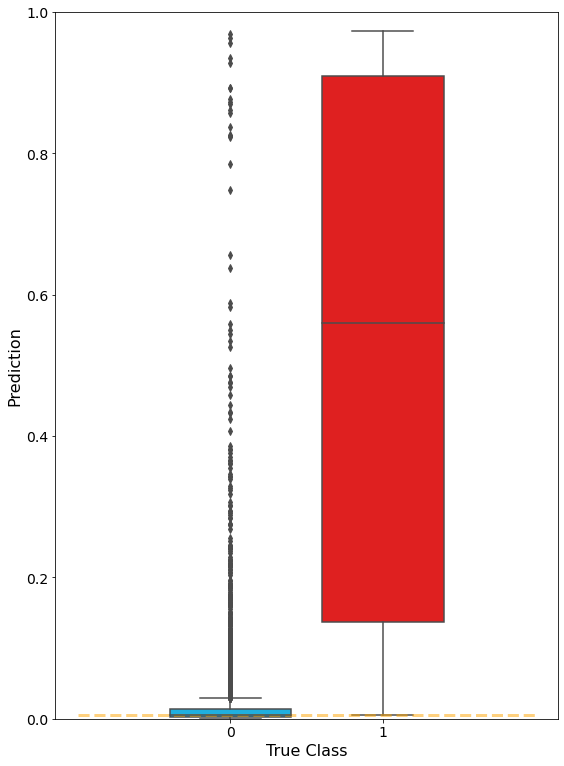

In [333]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

plt.figure(figsize=(9,13))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.boxplot(data=df_test_preds, x='true', y='pred', palette=my_pal)
plt.plot([-1, 2], [0.0051217, 0.0051217], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

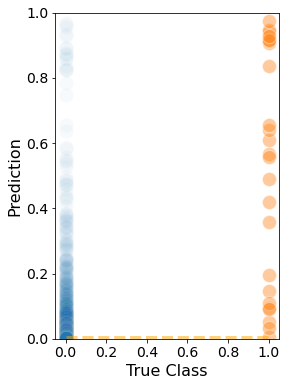

In [334]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

plt.figure(figsize=(4,6))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 0], x='true', y='pred', alpha=0.03, s=200)
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 1], x='true', y='pred', alpha=0.4, s=200)
plt.plot([-0, 1], [0.0051217, 0.0051217], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

In [335]:
thresh = 0.0051217

preds = df_test_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_test_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_test_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_test_preds['true'], preds), 3)))

[[2695 2939]
 [   0   24]]

Recall (TPR): 1.0

FPR: 0.522

Precision: 0.008


In [338]:
thresh = 0.0337549

preds = df_test_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_test_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_test_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_test_preds['true'], preds), 3)))

[[5121  513]
 [   1   23]]

Recall (TPR): 0.958

FPR: 0.091

Precision: 0.043


### 6.3) Random Forest (hyper-parameter tuned on AUC metric)

In [193]:
models[2][1]

Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=1.0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', min_samples_leaf=2,
                                        min_samples_split=3, n_estimators=80,
                                        random_state=42))])

In [197]:
cv_aurocs(X_tr.iloc[:, 0:71], y_tr['mort30'], models[2][1], 5)


CV AUROCs: [0.929, 0.915, 0.942, 0.922, 0.921]
Mean CV AUROC: 0.926 +/- 0.009


Training Set AUROC: 0.9675537061847996
Test Set AUROC: 0.9502499704177021






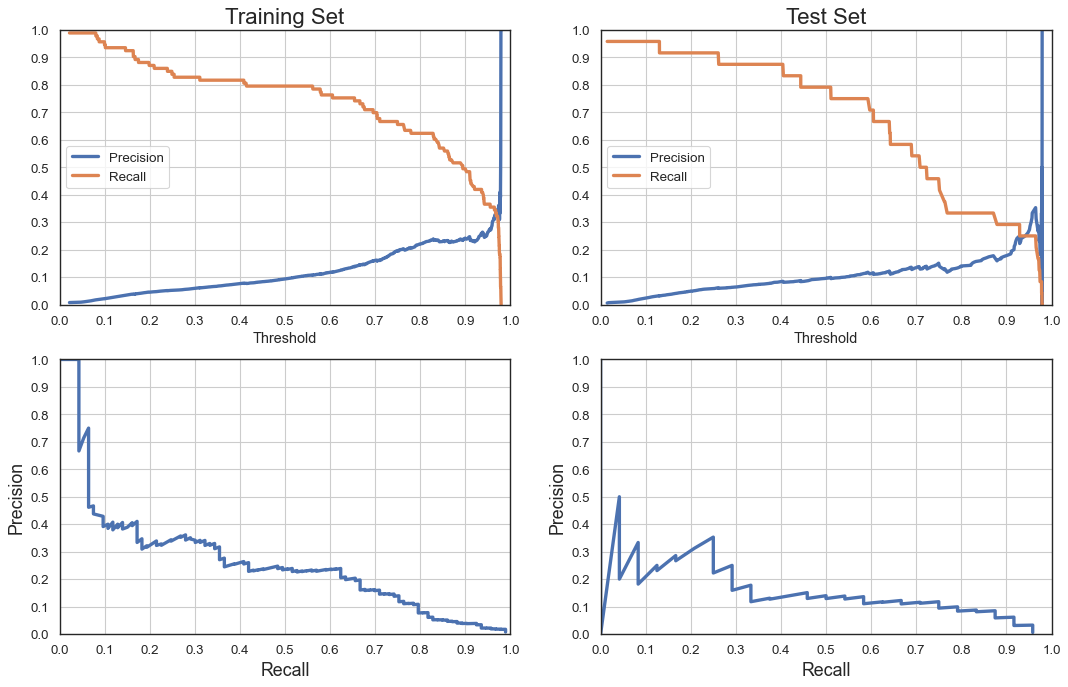

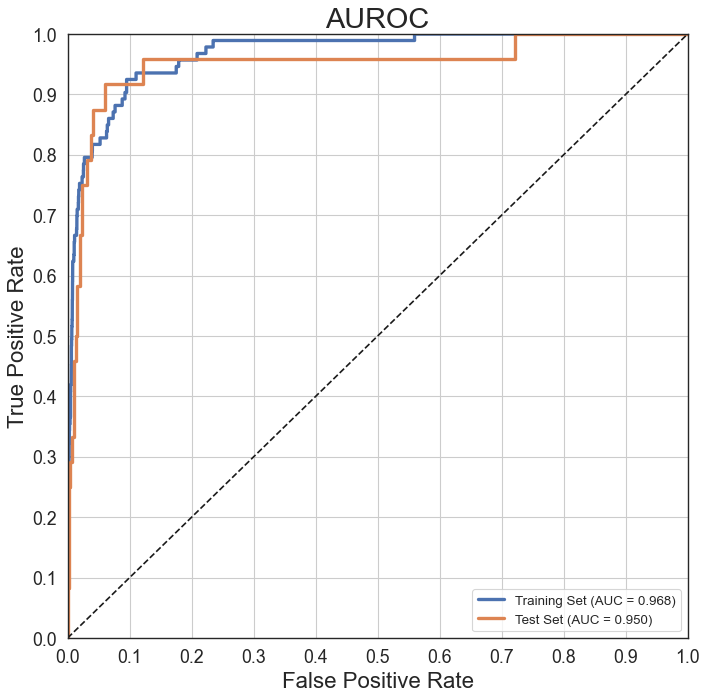

In [848]:
models[2][1].fit(X_tr.iloc[:, 0:71], y_tr['mort30'])

y_tr_pred = models[2][1].predict_proba(X_tr.iloc[:, 0:71])[:,1]

y_test_pred = models[2][1].predict_proba(X_test.iloc[:, 0:71])[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_tr['mort30'], y_tr_pred)))
print('Test Set AUROC: {}'.format(roc_auc_score(y_test['mort30'], y_test_pred)))
print('\n')
plot_prec_recall(y_tr['mort30'], y_tr_pred, y_test['mort30'], y_test_pred, test=True)
print ('\n')
plot_aurocs(y_tr['mort30'], y_tr_pred, y_test['mort30'], y_test_pred, test=True)

In [346]:
fpr, tpr, thresholds = roc_curve(y_test['mort30'], y_test_pred)
auc_data = pd.DataFrame(data={'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

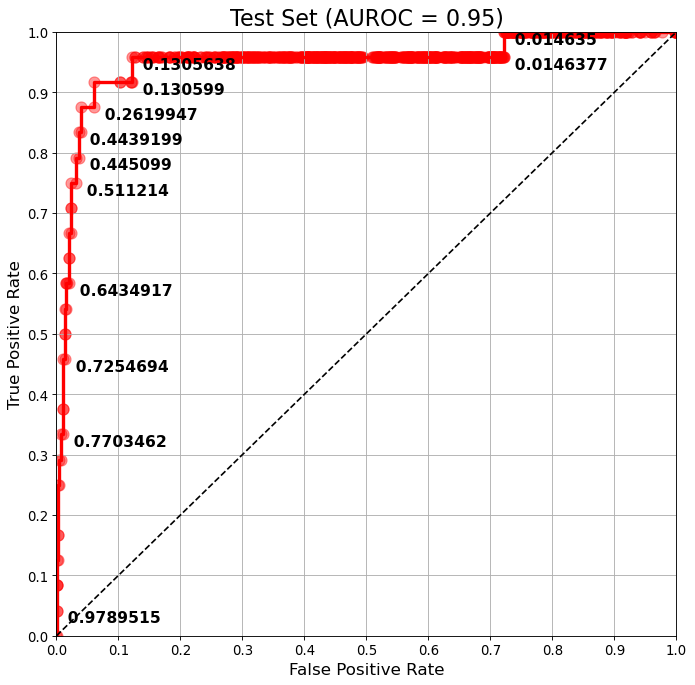

In [365]:
plt.figure(figsize=(10,10), dpi=80)
plt.plot(auc_data['fpr'], auc_data['tpr'], lw=3, color='red')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.scatter(auc_data['fpr'], auc_data['tpr'], s=100, color='red', alpha=0.4)

annotations = [str(round(thresh,7)) for thresh in thresholds]
annotations[0] = '1.0'
for i, label in enumerate(annotations):
    if i in [2, 16, 20, 28, 36, 38, 39, 42, 48, 49, 633, 634]:
        plt.annotate('  ' + label, (auc_data['fpr'][i], auc_data['tpr'][i]),
                     horizontalalignment='left',
                     verticalalignment='top',
                     weight='bold', size=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.grid(b=True)
plt.title('Test Set (AUROC = ' + str(round(roc_auc_score(y_test['mort30'], y_test_pred), 3)) + ')', 
          size=20)
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.xticks(size=12)
plt.yticks(size=12);

In [368]:
df_test_preds = pd.DataFrame(data=y_test['mort30'].values, columns=['true'])
df_test_preds['pred'] = y_test_pred

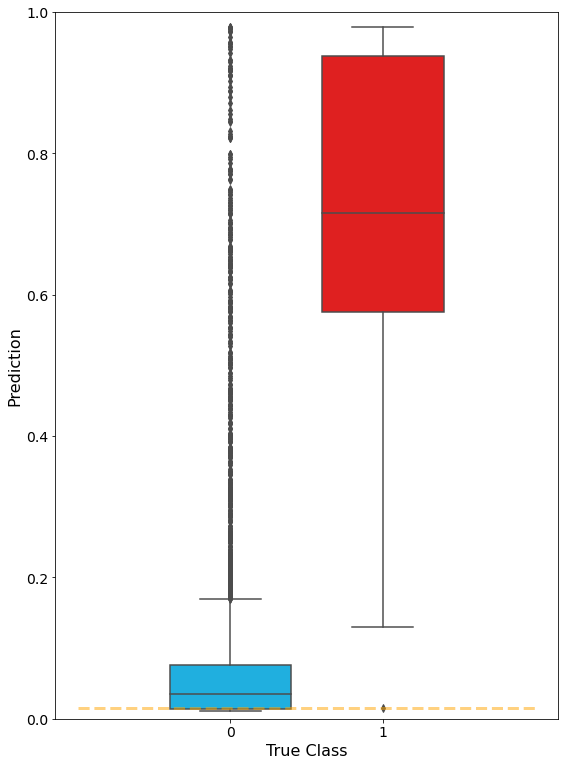

In [369]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

plt.figure(figsize=(9,13))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.boxplot(data=df_test_preds, x='true', y='pred', palette=my_pal)
plt.plot([-1, 2], [0.014635, 0.014635], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

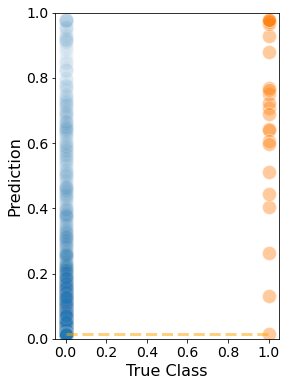

In [370]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

plt.figure(figsize=(4,6))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 0], x='true', y='pred', alpha=0.03, s=200)
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 1], x='true', y='pred', alpha=0.4, s=200)
plt.plot([-0, 1], [0.014635, 0.014635], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

In [372]:
thresh = 0.014634

preds = df_test_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_test_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_test_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_test_preds['true'], preds), 3)))

[[1566 4068]
 [   0   24]]

Recall (TPR): 1.0

FPR: 0.722

Precision: 0.006


In [375]:
thresh = 0.1305638

preds = df_test_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_test_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_test_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_test_preds['true'], preds), 3)))

[[4946  688]
 [   1   23]]

Recall (TPR): 0.958

FPR: 0.122

Precision: 0.032


### 6.4) Random Forest (hyper-parameter tuned on log-loss metric)

In [199]:
models[3][1]

Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=1.0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        min_samples_leaf=6, min_samples_split=3,
                                        random_state=42))])

In [200]:
cv_aurocs(X_tr.iloc[:, 0:71], y_tr['mort30'], models[3][1], 5)


CV AUROCs: [0.93, 0.923, 0.938, 0.924, 0.92]
Mean CV AUROC: 0.927 +/- 0.006


Training Set AUROC: 0.9671152201877236
Test Set AUROC: 0.9486673174772215






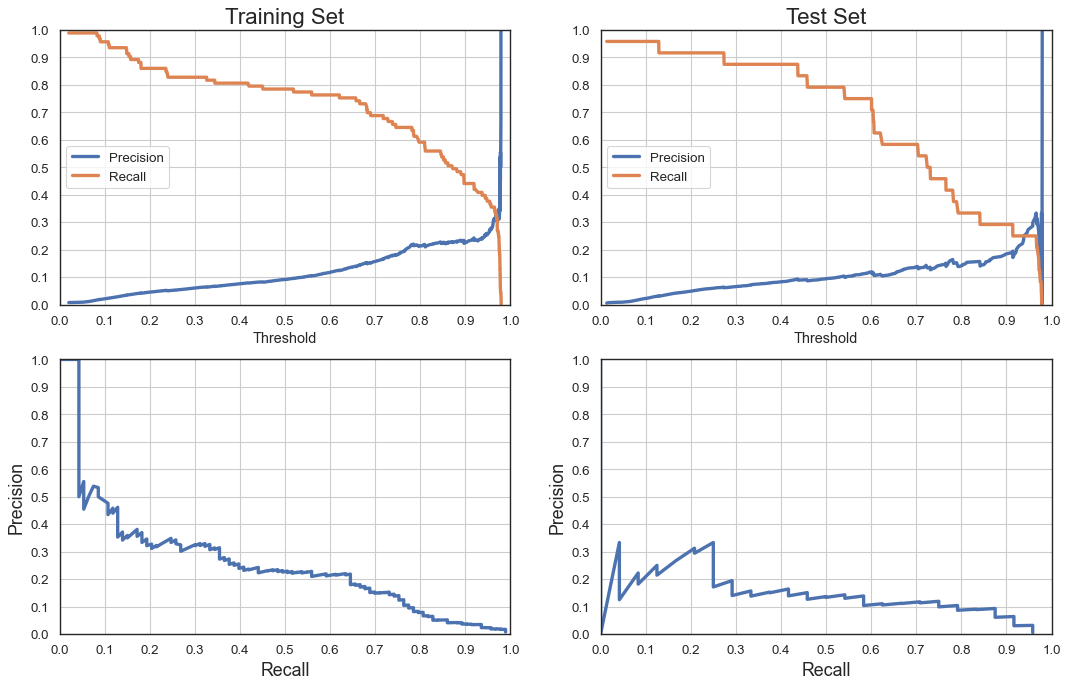

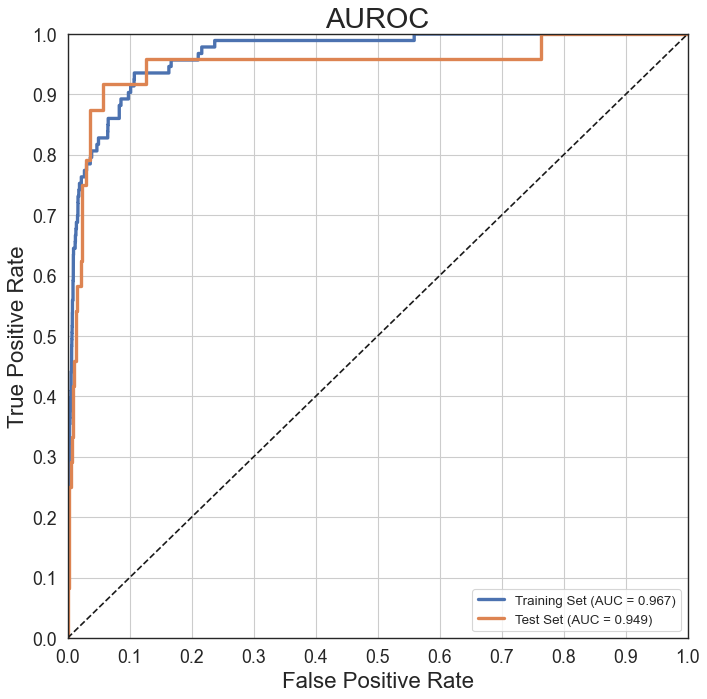

In [849]:
models[3][1].fit(X_tr.iloc[:, 0:71], y_tr['mort30'])

y_tr_pred = models[3][1].predict_proba(X_tr.iloc[:, 0:71])[:,1]

y_test_pred = models[3][1].predict_proba(X_test.iloc[:, 0:71])[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_tr['mort30'], y_tr_pred)))
print('Test Set AUROC: {}'.format(roc_auc_score(y_test['mort30'], y_test_pred)))
print('\n')
plot_prec_recall(y_tr['mort30'], y_tr_pred, y_test['mort30'], y_test_pred, test=True)
print ('\n')
plot_aurocs(y_tr['mort30'], y_tr_pred, y_test['mort30'], y_test_pred, test=True)

In [378]:
fpr, tpr, thresholds = roc_curve(y_test['mort30'], y_test_pred)
auc_data = pd.DataFrame(data={'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

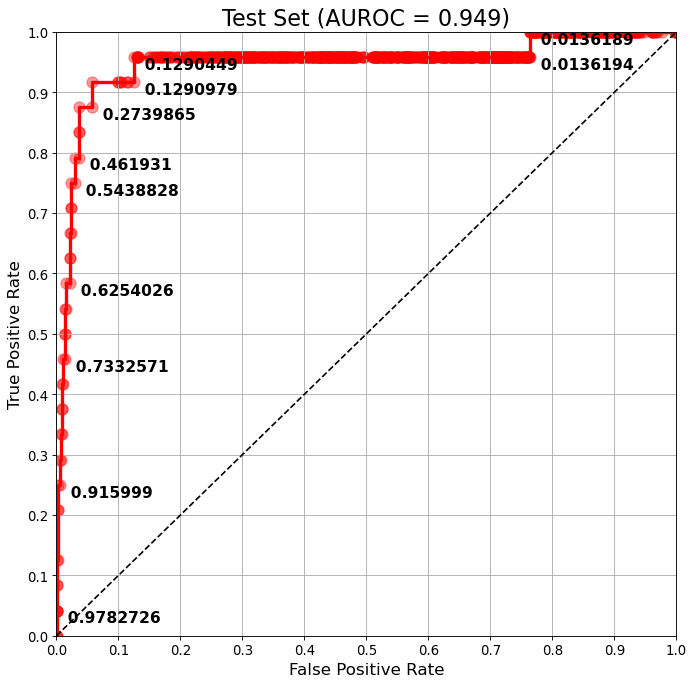

In [403]:
plt.figure(figsize=(10,10), dpi=80)
plt.plot(auc_data['fpr'], auc_data['tpr'], lw=3, color='red')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.scatter(auc_data['fpr'], auc_data['tpr'], s=100, color='red', alpha=0.4)

annotations = [str(round(thresh,7)) for thresh in thresholds]
annotations[0] = '1.0'
for i, label in enumerate(annotations):
    if i in [3, 14, 24, 30, 38, 40, 44, 52, 53, 721, 722]:
        plt.annotate('  ' + label, (auc_data['fpr'][i], auc_data['tpr'][i]),
                     horizontalalignment='left',
                     verticalalignment='top',
                     weight='bold', size=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.grid(b=True)
plt.title('Test Set (AUROC = ' + str(round(roc_auc_score(y_test['mort30'], y_test_pred), 3)) + ')', 
          size=20)
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.xticks(size=12)
plt.yticks(size=12);

In [404]:
df_test_preds = pd.DataFrame(data=y_test['mort30'].values, columns=['true'])
df_test_preds['pred'] = y_test_pred

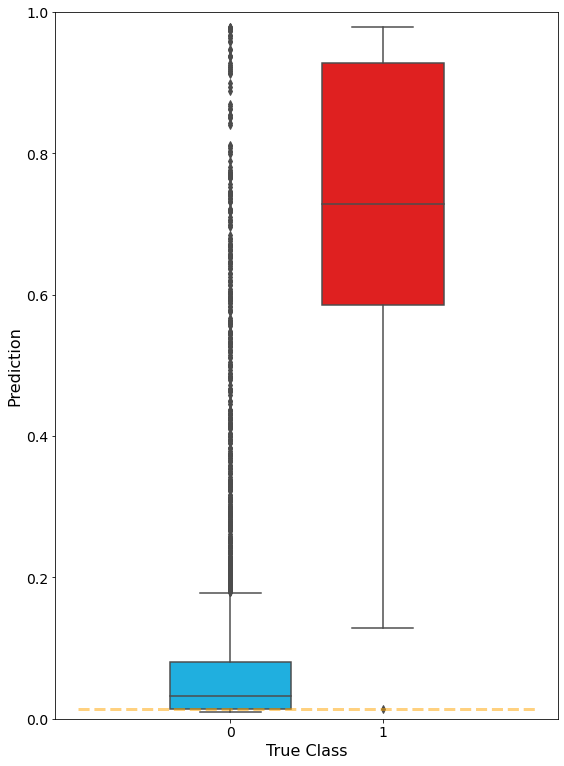

In [405]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

plt.figure(figsize=(9,13))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.boxplot(data=df_test_preds, x='true', y='pred', palette=my_pal)
plt.plot([-1, 2], [0.0136189, 0.0136189], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

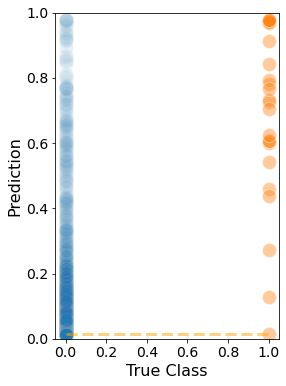

In [406]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

plt.figure(figsize=(4,6))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 0], x='true', y='pred', alpha=0.03, s=200)
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 1], x='true', y='pred', alpha=0.4, s=200)
plt.plot([-0, 1], [0.0136189, 0.0136189], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

In [408]:
thresh = 0.0136188

preds = df_test_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_test_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_test_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_test_preds['true'], preds), 3)))

[[1332 4302]
 [   0   24]]

Recall (TPR): 1.0

FPR: 0.764

Precision: 0.006


In [410]:
thresh = 0.1290448

preds = df_test_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_test_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_test_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_test_preds['true'], preds), 3)))

[[4926  708]
 [   1   23]]

Recall (TPR): 0.958

FPR: 0.126

Precision: 0.031


### 6.5) XGBoost (hyper-parameter tuned on log-loss metric)

In [206]:
models[4][1]

Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=0.01)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.3, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=4, missing=nan,
                               monotone_constraints='()', n_estimators=1000,
                               n_jobs=6, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.4, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=

In [207]:
cv_aurocs(X_tr.iloc[:, 0:71], y_tr['mort30'], models[4][1], 5)

[18:32:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[18:33:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[18:33:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[18:33:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[18:33:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

CV AUROCs: [0.945, 0.918, 0.924, 0.936, 0.924]
Mean CV AUROC: 0.929 +/- 0.01


/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[22:52:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Training Set AUROC: 0.979994732442429
Test Set AUROC: 0.9583924979292392






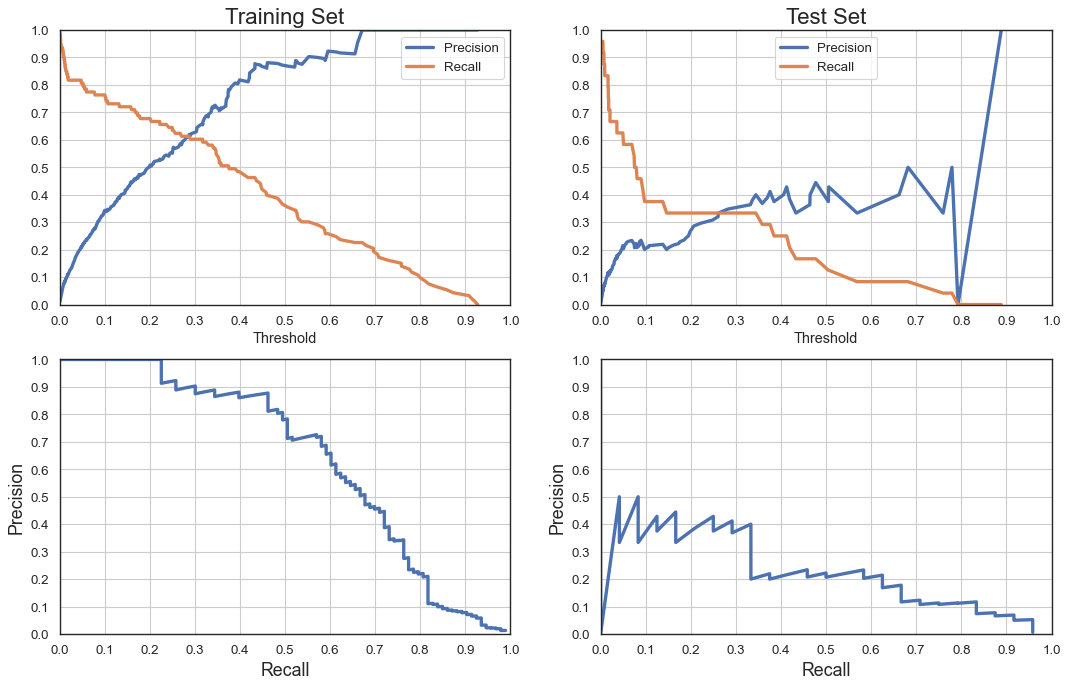

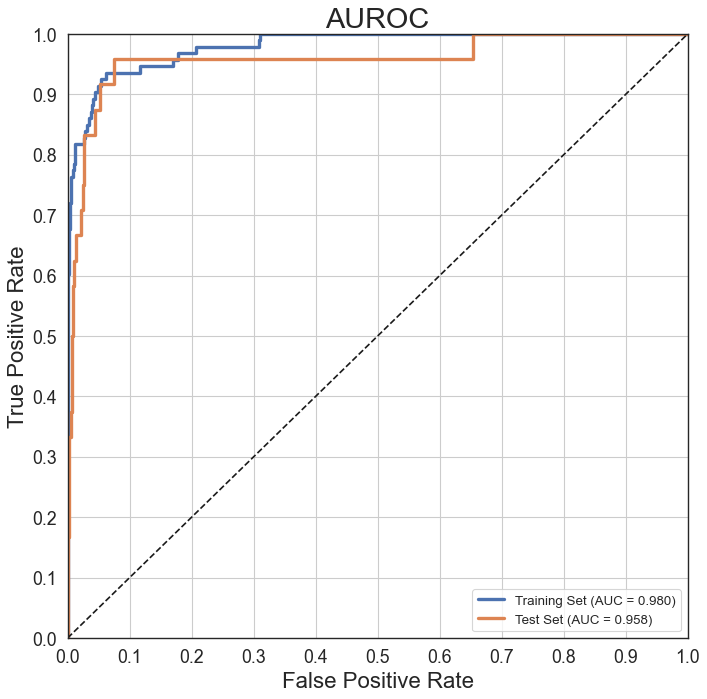

In [850]:
models[4][1].fit(X_tr.iloc[:, 0:71], y_tr['mort30'])

y_tr_pred = models[4][1].predict_proba(X_tr.iloc[:, 0:71])[:,1]

y_test_pred = models[4][1].predict_proba(X_test.iloc[:, 0:71])[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_tr['mort30'], y_tr_pred)))
print('Test Set AUROC: {}'.format(roc_auc_score(y_test['mort30'], y_test_pred)))
print('\n')
plot_prec_recall(y_tr['mort30'], y_tr_pred, y_test['mort30'], y_test_pred, test=True)
print ('\n')
plot_aurocs(y_tr['mort30'], y_tr_pred, y_test['mort30'], y_test_pred, test=True)

In [412]:
fpr, tpr, thresholds = roc_curve(y_test['mort30'], y_test_pred)
auc_data = pd.DataFrame(data={'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

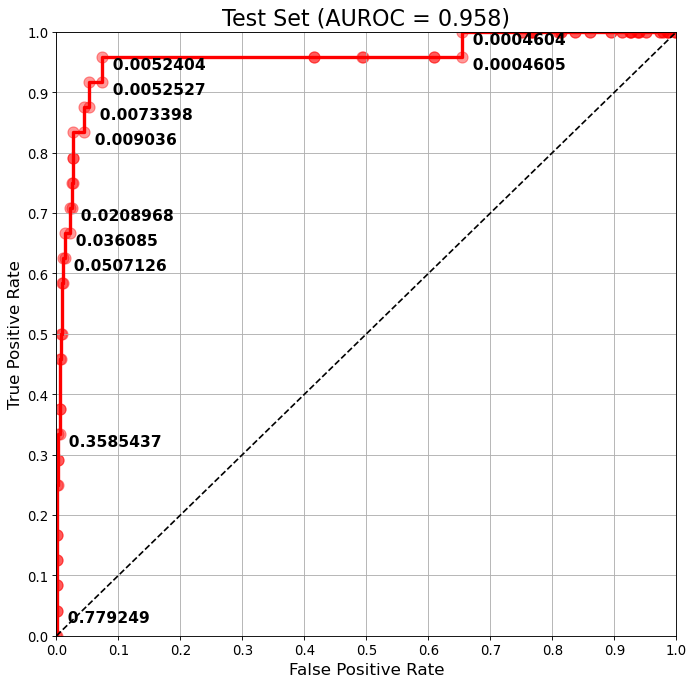

In [424]:
plt.figure(figsize=(10,10), dpi=80)
plt.plot(auc_data['fpr'], auc_data['tpr'], lw=3, color='red')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.scatter(auc_data['fpr'], auc_data['tpr'], s=100, color='red', alpha=0.4)

annotations = [str(round(thresh,7)) for thresh in thresholds]
annotations[0] = '1.0'
for i, label in enumerate(annotations):
    if i in [3, 14, 24, 26, 28, 35, 37, 39, 40, 47, 48]:
        plt.annotate('  ' + label, (auc_data['fpr'][i], auc_data['tpr'][i]),
                     horizontalalignment='left',
                     verticalalignment='top',
                     weight='bold', size=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.grid(b=True)
plt.title('Test Set (AUROC = ' + str(round(roc_auc_score(y_test['mort30'], y_test_pred), 3)) + ')', 
          size=20)
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.xticks(size=12)
plt.yticks(size=12);

In [425]:
df_test_preds = pd.DataFrame(data=y_test['mort30'].values, columns=['true'])
df_test_preds['pred'] = y_test_pred

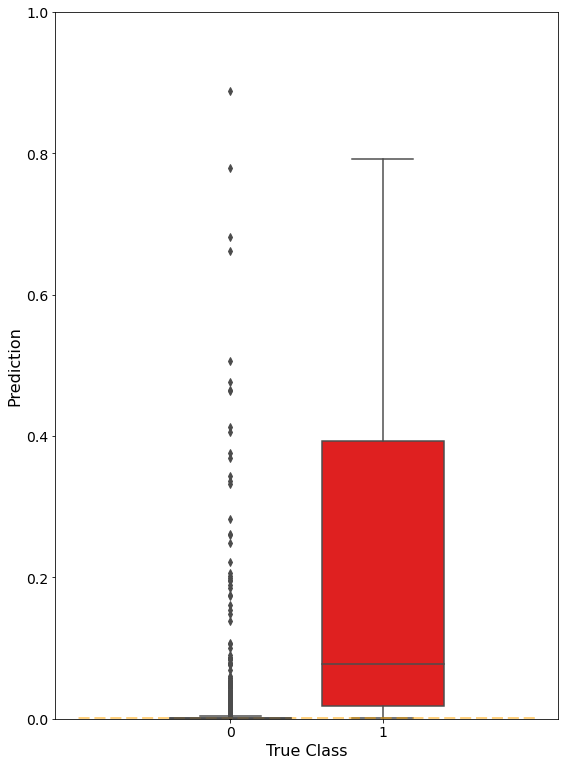

In [426]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

plt.figure(figsize=(9,13))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.boxplot(data=df_test_preds, x='true', y='pred', palette=my_pal)
plt.plot([-1, 2], [0.0004604, 0.0004604], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

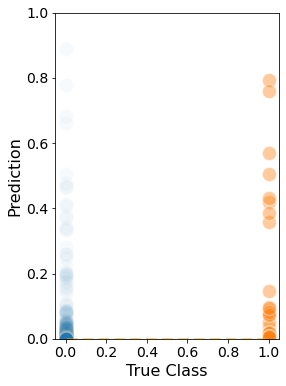

In [427]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

plt.figure(figsize=(4,6))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 0], x='true', y='pred', alpha=0.03, s=200)
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 1], x='true', y='pred', alpha=0.4, s=200)
plt.plot([-0, 1], [0.0004604, 0.0004604], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

In [428]:
thresh = 0.0004604

preds = df_test_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_test_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_test_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_test_preds['true'], preds), 3)))

[[1951 3683]
 [   0   24]]

Recall (TPR): 1.0

FPR: 0.654

Precision: 0.006


In [439]:
thresh = 0.0052404

preds = df_test_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_test_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_test_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_test_preds['true'], preds), 3)))

[[5217  417]
 [   1   23]]

Recall (TPR): 0.958

FPR: 0.074

Precision: 0.052


### 6.6) XGBoost (hyper-parameter tuned on AUC metric)

In [209]:
models[5][1]

Pipeline(steps=[('smote', SMOTE(random_state=42, sampling_strategy=1.0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.2, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=5, missing=nan,
                               monotone_constraints='()', n_estimators=300,
                               n_jobs=6, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.2, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=No

In [210]:
cv_aurocs(X_tr.iloc[:, 0:71], y_tr['mort30'], models[5][1], 5)

[18:34:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[18:34:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[18:34:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[18:34:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[18:35:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

CV AUROCs: [0.932, 0.935, 0.928, 0.932, 0.921]
Mean CV AUROC: 0.93 +/- 0.005


/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[22:57:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Training Set AUROC: 0.9656990869566877
Test Set AUROC: 0.9575124245651403






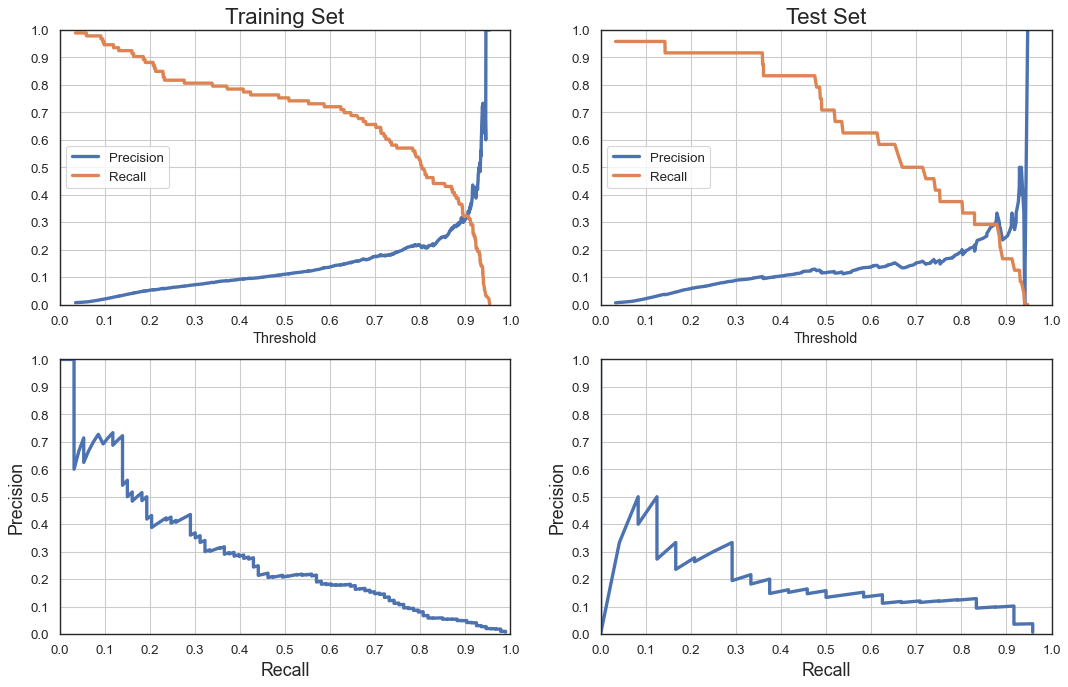

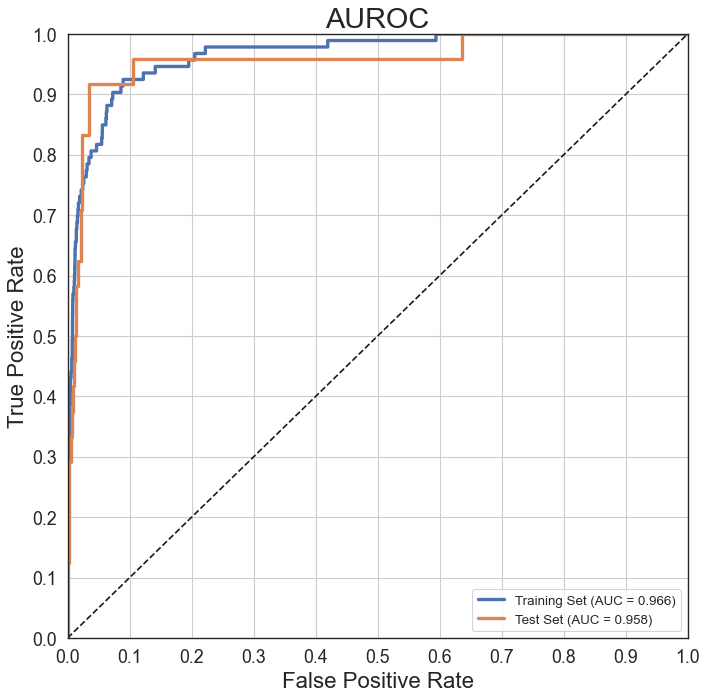

In [852]:
models[5][1].fit(X_tr.iloc[:, 0:71], y_tr['mort30'])

y_tr_pred = models[5][1].predict_proba(X_tr.iloc[:, 0:71])[:,1]

y_test_pred = models[5][1].predict_proba(X_test.iloc[:, 0:71])[:,1]

print('Training Set AUROC: {}'.format(roc_auc_score(y_tr['mort30'], y_tr_pred)))
print('Test Set AUROC: {}'.format(roc_auc_score(y_test['mort30'], y_test_pred)))
print('\n')
plot_prec_recall(y_tr['mort30'], y_tr_pred, y_test['mort30'], y_test_pred, test=True)
print ('\n')
plot_aurocs(y_tr['mort30'], y_tr_pred, y_test['mort30'], y_test_pred, test=True)

In [443]:
fpr, tpr, thresholds = roc_curve(y_test['mort30'], y_test_pred)
auc_data = pd.DataFrame(data={'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

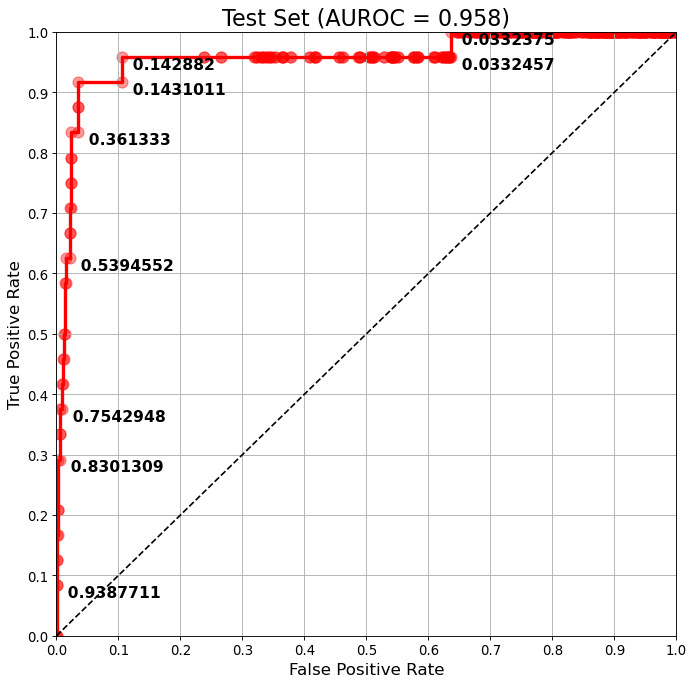

In [461]:
plt.figure(figsize=(10,10), dpi=80)
plt.plot(auc_data['fpr'], auc_data['tpr'], lw=3, color='red')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.scatter(auc_data['fpr'], auc_data['tpr'], s=100, color='red', alpha=0.4)

annotations = [str(round(thresh,7)) for thresh in thresholds]
annotations[0] = '1.0'
for i, label in enumerate(annotations):
    if i in [3, 12, 16, 26, 36, 40, 41, 129, 130]:
        plt.annotate('  ' + label, (auc_data['fpr'][i], auc_data['tpr'][i]),
                     horizontalalignment='left',
                     verticalalignment='top',
                     weight='bold', size=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.grid(b=True)
plt.title('Test Set (AUROC = ' + str(round(roc_auc_score(y_test['mort30'], y_test_pred), 3)) + ')', 
          size=20)
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.xticks(size=12)
plt.yticks(size=12);

In [462]:
df_test_preds = pd.DataFrame(data=y_test['mort30'].values, columns=['true'])
df_test_preds['pred'] = y_test_pred

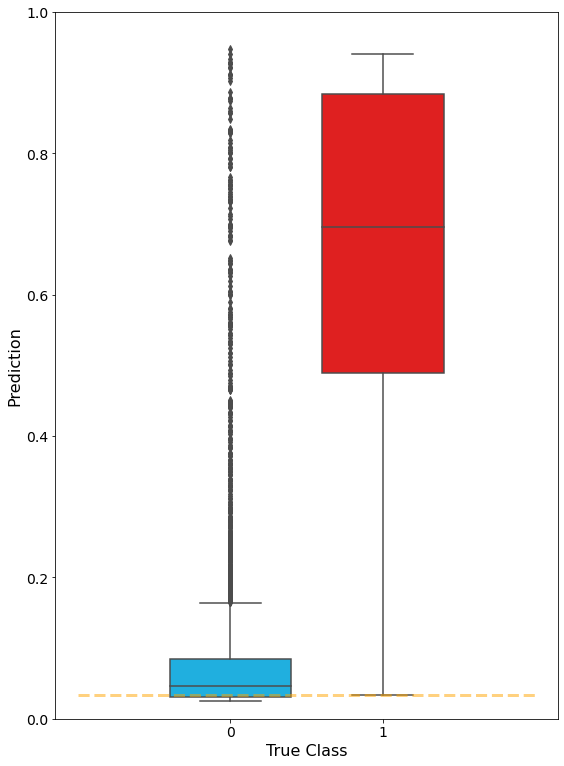

In [463]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

plt.figure(figsize=(9,13))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.boxplot(data=df_test_preds, x='true', y='pred', palette=my_pal)
plt.plot([-1, 2], [0.0332375, 0.0332375], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

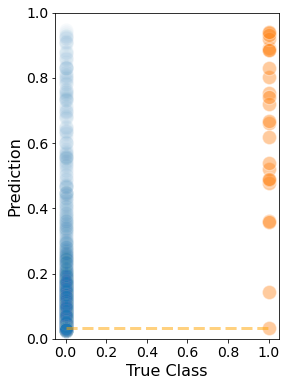

In [464]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

plt.figure(figsize=(4,6))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 0], x='true', y='pred', alpha=0.03, s=200)
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 1], x='true', y='pred', alpha=0.4, s=200)
plt.plot([-0, 1], [0.0332375, 0.0332375], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

In [465]:
thresh = 0.0332375

preds = df_test_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_test_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_test_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_test_preds['true'], preds), 3)))

[[2050 3584]
 [   0   24]]

Recall (TPR): 1.0

FPR: 0.636

Precision: 0.007


In [468]:
thresh = 0.142881

preds = df_test_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_test_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_test_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_test_preds['true'], preds), 3)))

[[5040  594]
 [   1   23]]

Recall (TPR): 0.958

FPR: 0.105

Precision: 0.037


### 6.7) Ensemble of all 6 models above

In [853]:
estimator_list = [('estimator_0', pipe0),
                  ('estimator_1', pipe1),
                  ('estimator_2', pipe2),
                  ('estimator_3', pipe3),
                  ('estimator_4', pipe4),
                  ('estimator_5', pipe5)]

In [854]:
vc_final = VotingClassifier(estimators=estimator_list, voting='soft', weights=None)

In [855]:
vc_final.fit(X_tr, y_tr['mort30'])

[00:34:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:34:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('estimator_0',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('passthrough',
                                                                                'passthrough',
                                                                                slice(71, 141, None))])),
                                              ('pipeline',
                                               Pipeline(steps=[('smote',
                                                                SMOTE(random_state=42,
                                                                      sampling_strategy=1.0)),
                                                               ('logisticregression',
                                                                LogisticRegression(C=5e-06,
                                                                                   l1_ratio=0,
    

In [857]:
y_train_preds_vc = vc_final.predict_proba(X_tr)[:, 1]
y_test_preds_vc = vc_final.predict_proba(X_test)[:, 1]

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Training Set AUROC: 0.9639935720529351
Test Set AUROC: 0.9603819074665721






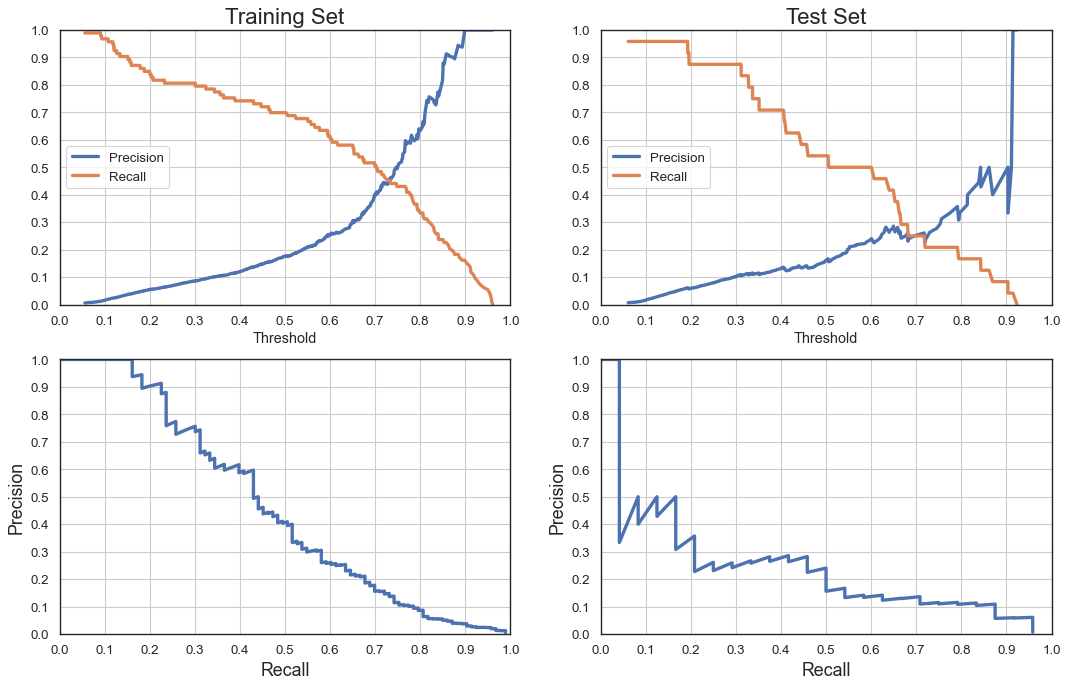

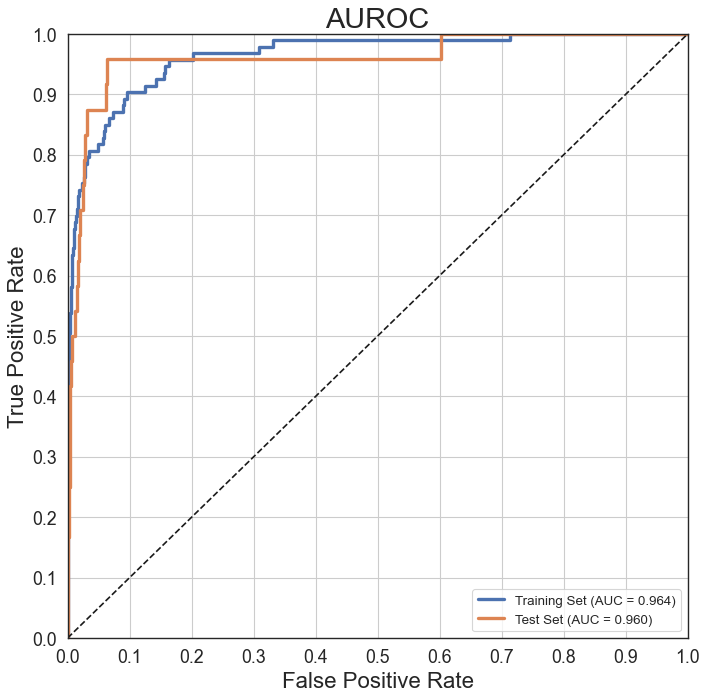

In [858]:
print('Training Set AUROC: {}'.format(roc_auc_score(y_tr['mort30'], y_train_preds_vc)))
print('Test Set AUROC: {}'.format(roc_auc_score(y_test['mort30'], y_test_preds_vc)))
print('\n')
plot_prec_recall(y_tr['mort30'], y_train_preds_vc, y_test['mort30'], y_test_preds_vc, test=True)
print ('\n')
plot_aurocs(y_tr['mort30'], y_train_preds_vc, y_test['mort30'], y_test_preds_vc, test=True)

In [266]:
fpr, tpr, thresholds = roc_curve(y_test['mort30'], y_test_preds_vc)
auc_data = pd.DataFrame(data={'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

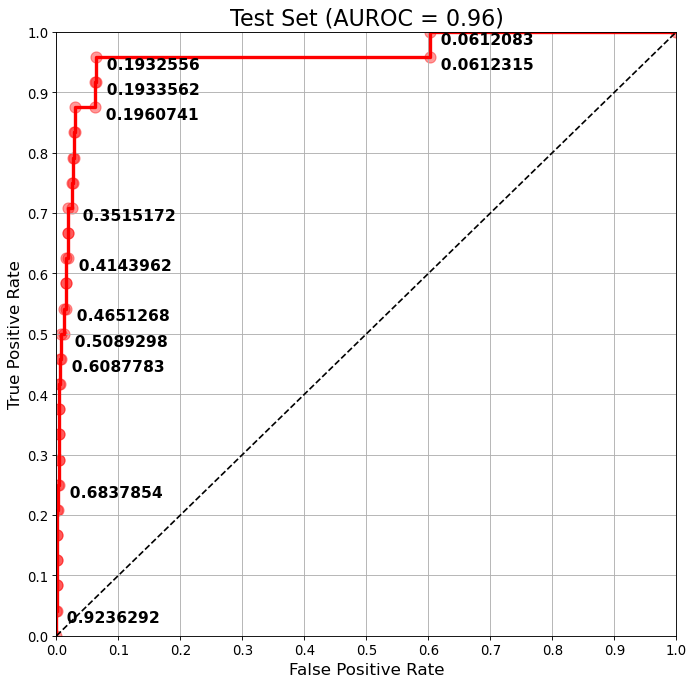

In [267]:
plt.figure(figsize=(10,10), dpi=80)
plt.plot(auc_data['fpr'], auc_data['tpr'], lw=3, color='red')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.scatter(auc_data['fpr'], auc_data['tpr'], s=100, color='red', alpha=0.4)

annotations = [str(round(thresh,7)) for thresh in thresholds]
annotations[0] = '1.0'
for i, label in enumerate(annotations):
    if i in [1, 12, 22, 24, 26, 30, 34, 42, 44, 45, 46, 47]:
        plt.annotate('  ' + label, (auc_data['fpr'][i], auc_data['tpr'][i]),
                     horizontalalignment='left',
                     verticalalignment='top',
                     weight='bold', size=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.grid(b=True)
plt.title('Test Set (AUROC = ' + str(round(roc_auc_score(y_test['mort30'], y_test_preds_vc), 3)) + ')', 
          size=20)
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.xticks(size=12)
plt.yticks(size=12);

In [268]:
df_test_preds = pd.DataFrame(data=y_test['mort30'].values, columns=['true'])
df_test_preds['pred'] = y_test_preds_vc

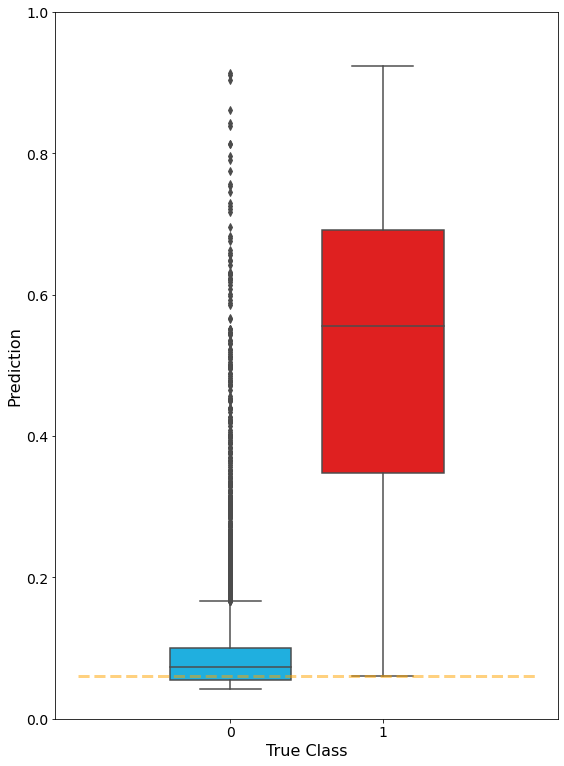

In [269]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

plt.figure(figsize=(9,13))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.boxplot(data=df_test_preds, x='true', y='pred', palette=my_pal)
plt.plot([-1, 2], [0.0612083, 0.0612083], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

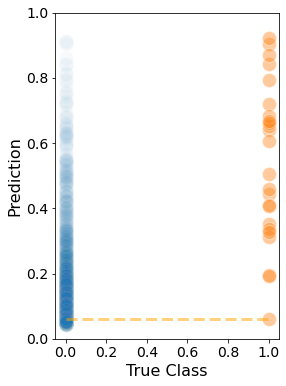

In [270]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

plt.figure(figsize=(4,6))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 0], x='true', y='pred', alpha=0.03, s=200)
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 1], x='true', y='pred', alpha=0.4, s=200)
plt.plot([-0, 1], [0.0612083, 0.0612083], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

In [272]:
thresh = 0.0612082

preds = df_test_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_test_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_test_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_test_preds['true'], preds), 3)))

[[2243 3391]
 [   0   24]]

Recall (TPR): 1.0

FPR: 0.602

Precision: 0.007


In [263]:
thresh = 0.1932556

preds = df_test_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_test_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_test_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_test_preds['true'], preds), 3)))

[[5278  356]
 [   1   23]]

Recall (TPR): 0.958

FPR: 0.063

Precision: 0.061


### 6.8) Ensemble of LR model, RF model & XGB model (all optimized to AUC)

In [859]:
estimator_list3 = [('estimator_0', pipe0),
                   ('estimator_2', pipe2),
                  ('estimator_5', pipe5)]

In [860]:
vc_final3 = VotingClassifier(estimators=estimator_list3, voting='soft', weights=None)

In [861]:
vc_final3.fit(X_tr, y_tr['mort30'])

[00:40:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('estimator_0',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('passthrough',
                                                                                'passthrough',
                                                                                slice(71, 141, None))])),
                                              ('pipeline',
                                               Pipeline(steps=[('smote',
                                                                SMOTE(random_state=42,
                                                                      sampling_strategy=1.0)),
                                                               ('logisticregression',
                                                                LogisticRegression(C=5e-06,
                                                                                   l1_ratio=0,
    

In [862]:
y_train_preds_vc = vc_final3.predict_proba(X_tr)[:, 1]
y_test_preds_vc = vc_final3.predict_proba(X_test)[:, 1]

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Training Set AUROC: 0.962073108355186
Test Set AUROC: 0.9600195243166489






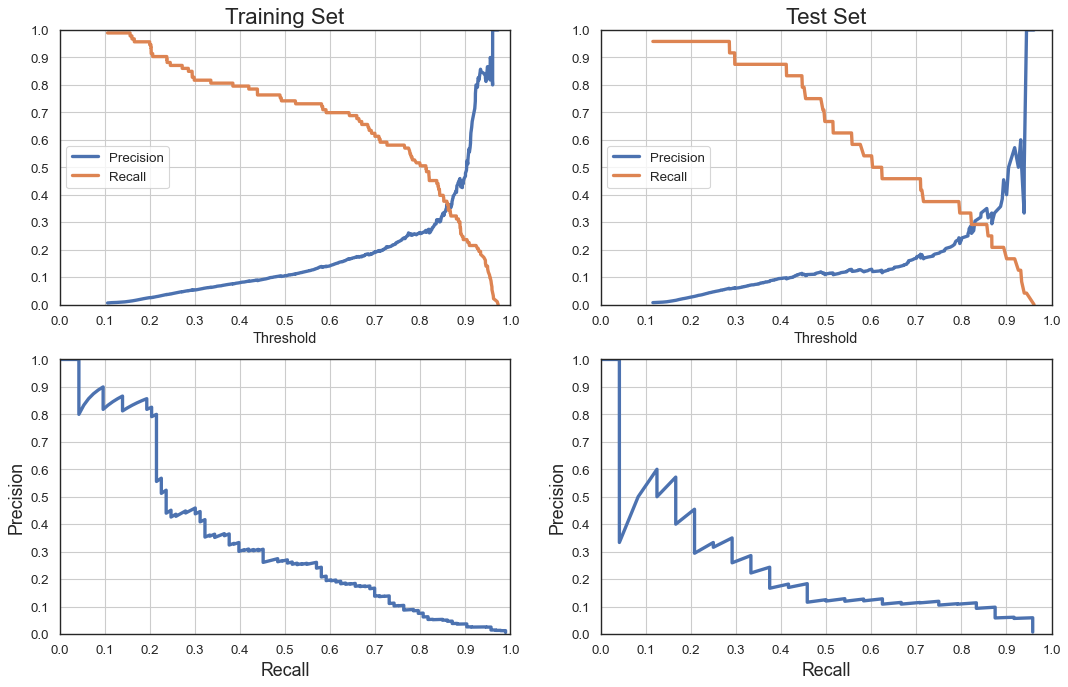

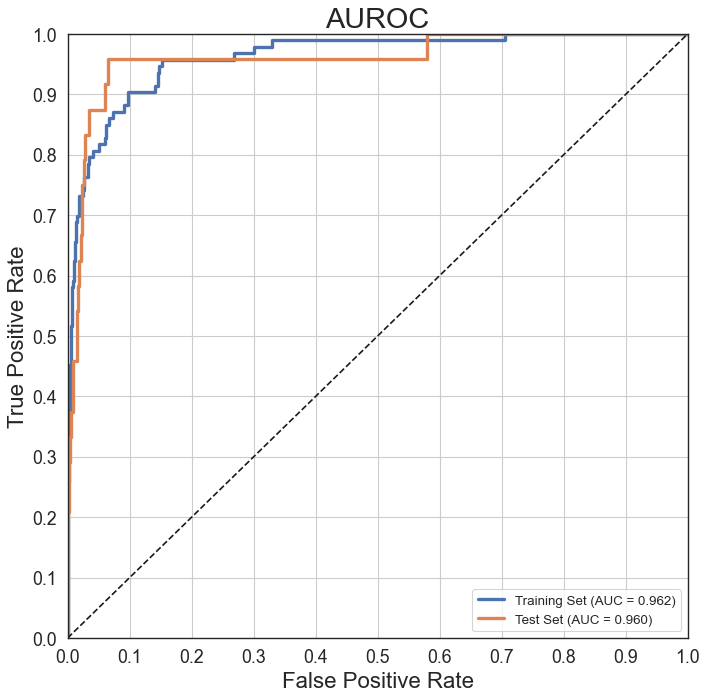

In [863]:
print('Training Set AUROC: {}'.format(roc_auc_score(y_tr['mort30'], y_train_preds_vc)))
print('Test Set AUROC: {}'.format(roc_auc_score(y_test['mort30'], y_test_preds_vc)))
print('\n')
plot_prec_recall(y_tr['mort30'], y_train_preds_vc, y_test['mort30'], y_test_preds_vc, test=True)
print ('\n')
plot_aurocs(y_tr['mort30'], y_train_preds_vc, y_test['mort30'], y_test_preds_vc, test=True)

In [864]:
fpr, tpr, thresholds = roc_curve(y_test['mort30'], y_test_preds_vc)
auc_data = pd.DataFrame(data={'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

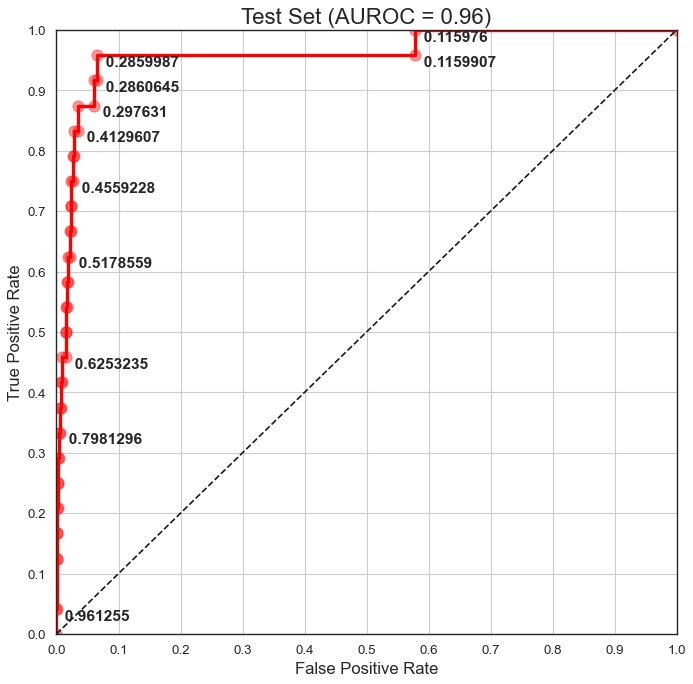

In [865]:
plt.figure(figsize=(10,10), dpi=80)
plt.plot(auc_data['fpr'], auc_data['tpr'], lw=3, color='red')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.scatter(auc_data['fpr'], auc_data['tpr'], s=100, color='red', alpha=0.4)

annotations = [str(round(thresh,7)) for thresh in thresholds]
annotations[0] = '1.0'
for i, label in enumerate(annotations):
    if i in [1, 14, 20, 28, 34, 38, 40, 42, 43, 44, 45]:
        plt.annotate('  ' + label, (auc_data['fpr'][i], auc_data['tpr'][i]),
                     horizontalalignment='left',
                     verticalalignment='top',
                     weight='bold', size=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.grid(b=True)
plt.title('Test Set (AUROC = ' + str(round(roc_auc_score(y_test['mort30'], y_test_preds_vc), 3)) + ')', 
          size=20)
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.xticks(size=12)
plt.yticks(size=12);

In [866]:
df_test_preds = pd.DataFrame(data=y_test['mort30'].values, columns=['true'])
df_test_preds['pred'] = y_test_preds_vc

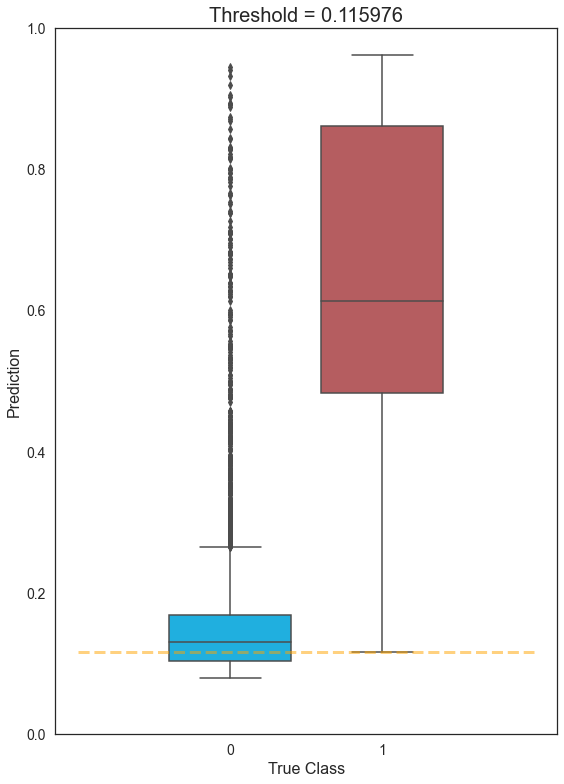

In [867]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

threshold = 0.115976

plt.figure(figsize=(9,13))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.boxplot(data=df_test_preds, x='true', y='pred', palette=my_pal)
plt.plot([-1, 2], [threshold, threshold], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0])
plt.title('Threshold = {}'.format(threshold), size=20);

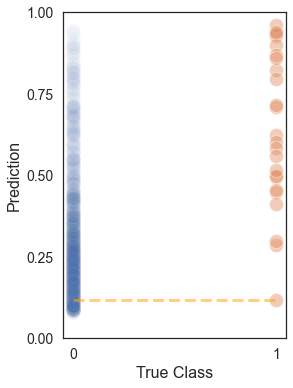

In [868]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

plt.figure(figsize=(4,6))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 0], x='true', y='pred', alpha=0.03, s=200)
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 1], x='true', y='pred', alpha=0.4, s=200)
plt.plot([-0, 1], [0.115976, 0.115976], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0]);

In [869]:
thresh = 0.115975

preds = df_test_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_test_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_test_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_test_preds['true'], preds), 3)))

[[2372 3262]
 [   0   24]]

Recall (TPR): 1.0

FPR: 0.579

Precision: 0.007


In [870]:
thresh = 0.2859986

preds = df_test_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)


C = confusion_matrix(df_test_preds['true'], preds)
print(C)
print('\nRecall (TPR): {}'.format(round(recall_score(df_test_preds['true'], preds), 3)))
print('\nFPR: {}'.format(round(C[0][1]/C[0].sum(), 3)))
print('\nPrecision: {}'.format(round(precision_score(df_test_preds['true'], preds), 3)))

[[5268  366]
 [   1   23]]

Recall (TPR): 0.958

FPR: 0.065

Precision: 0.059


### 6.9) Ensemble of LR model (optimized to AUC) & XGB model (optimized to AUC)

In [877]:
estimator_list2 = [('estimator_0', pipe0),
                  ('estimator_5', pipe5)]

In [878]:
vc_final2 = VotingClassifier(estimators=estimator_list2, voting='soft', weights=None)

In [879]:
vc_final2.fit(X_tr, y_tr['mort30'])

[00:48:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('estimator_0',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('passthrough',
                                                                                'passthrough',
                                                                                slice(71, 141, None))])),
                                              ('pipeline',
                                               Pipeline(steps=[('smote',
                                                                SMOTE(random_state=42,
                                                                      sampling_strategy=1.0)),
                                                               ('logisticregression',
                                                                LogisticRegression(C=5e-06,
                                                                                   l1_ratio=0,
    

In [880]:
y_train_preds_vc = vc_final2.predict_proba(X_tr)[:, 1]
y_test_preds_vc = vc_final2.predict_proba(X_test)[:, 1]

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Training Set AUROC: 0.9577865379550426
Test Set AUROC: 0.9637394982842268






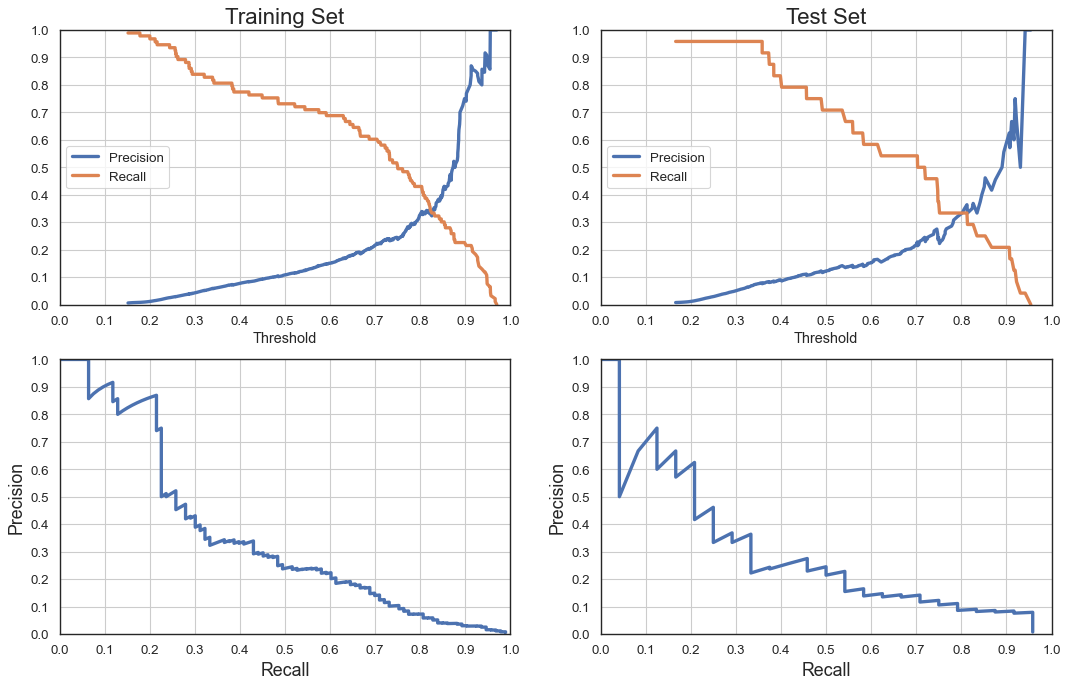

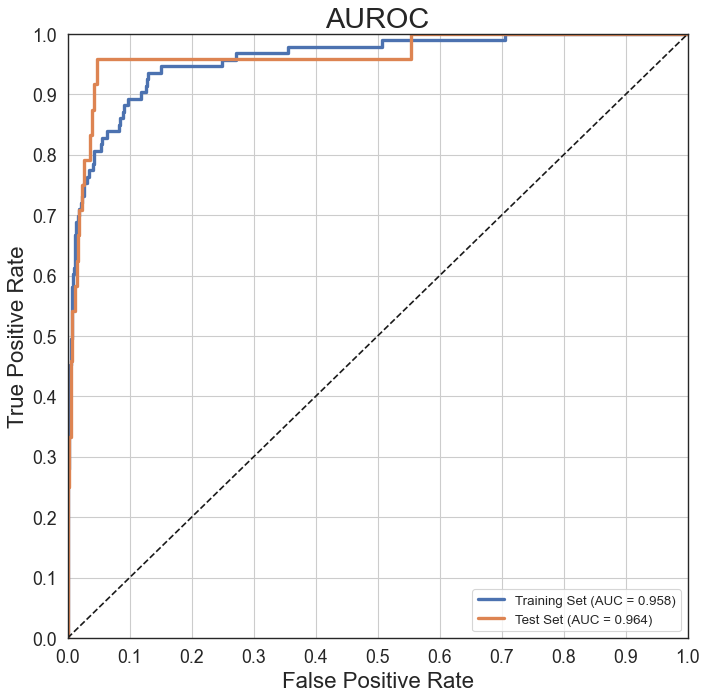

In [881]:
print('Training Set AUROC: {}'.format(roc_auc_score(y_tr['mort30'], y_train_preds_vc)))
print('Test Set AUROC: {}'.format(roc_auc_score(y_test['mort30'], y_test_preds_vc)))
print('\n')
plot_prec_recall(y_tr['mort30'], y_train_preds_vc, y_test['mort30'], y_test_preds_vc, test=True)
print ('\n')
plot_aurocs(y_tr['mort30'], y_train_preds_vc, y_test['mort30'], y_test_preds_vc, test=True)

In [882]:
fpr, tpr, thresholds = roc_curve(y_test['mort30'], y_test_preds_vc)
auc_data = pd.DataFrame(data={'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

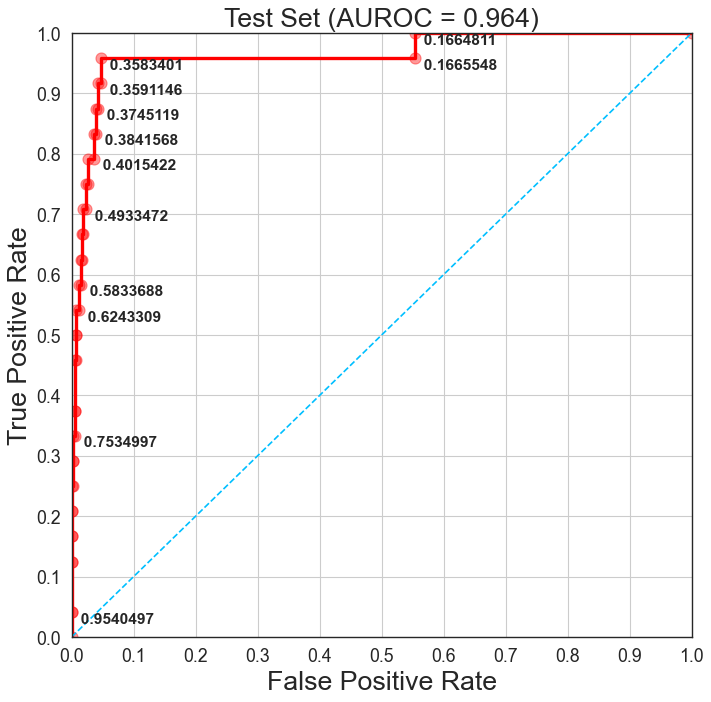

In [883]:
plt.figure(figsize=(10,10), dpi=80)
plt.plot(auc_data['fpr'], auc_data['tpr'], lw=3, color='red')
plt.plot([0, 1], [0, 1], '--', color='deepskyblue')  # random predictions curve
plt.scatter(auc_data['fpr'], auc_data['tpr'], s=100, color='red', alpha=0.4)

annotations = [str(round(thresh,7)) for thresh in thresholds]
annotations[0] = '1.0'
for i, label in enumerate(annotations):
    if i in [1, 14, 22, 24, 30, 34, 36, 38, 40, 41, 42, 43]:
        plt.annotate('  ' + label, (auc_data['fpr'][i], auc_data['tpr'][i]),
                     horizontalalignment='left',
                     verticalalignment='top',
                     weight='bold', size=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.grid(b=True)
plt.title('Test Set (AUROC = ' + str(round(roc_auc_score(y_test['mort30'], y_test_preds_vc), 3)) + ')', 
          size=24)
plt.xlabel('False Positive Rate', size=24)
plt.ylabel('True Positive Rate', size=24)
plt.xticks(size=16)
plt.yticks(size=16);

In [884]:
df_test_preds = pd.DataFrame(data=y_test['mort30'].values, columns=['true'])
df_test_preds['pred'] = y_test_preds_vc

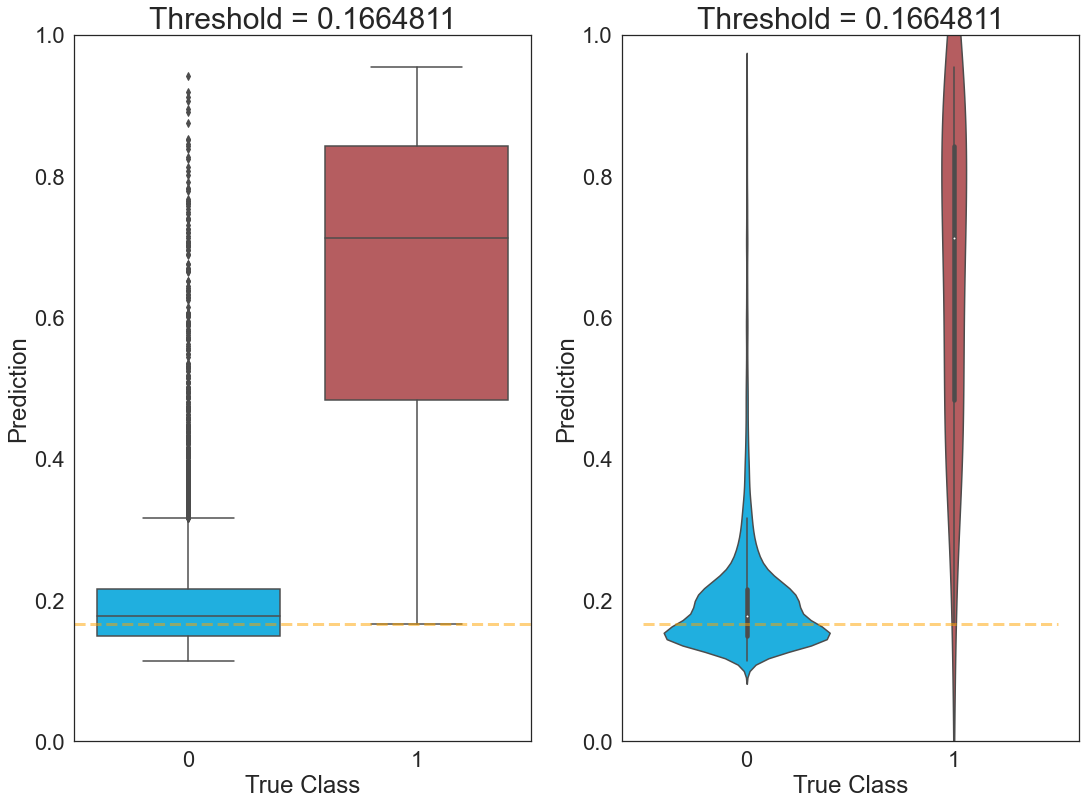

In [885]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

threshold = 0.1664811

plt.figure(figsize=(18,13))
plt.subplot(1, 2, 1)
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.boxplot(data=df_test_preds, x='true', y='pred', palette=my_pal)
plt.plot([-0.5, 1.5], [threshold, threshold], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=24)
plt.ylabel('Prediction', size=24)
plt.xticks(size=22)
plt.yticks(size=22)
plt.ylim([0.0, 1.0])
plt.title('Threshold = {}'.format(threshold), size=30)

plt.subplot(1, 2, 2)
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.violinplot(data=df_test_preds, x='true', y='pred', palette=my_pal)
plt.plot([-0.5, 1.5], [threshold, threshold], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=24)
plt.ylabel('Prediction', size=24)
plt.xticks(size=22)
plt.yticks(size=22)
plt.ylim([0.0, 1.0])
plt.title('Threshold = {}'.format(threshold), size=30);

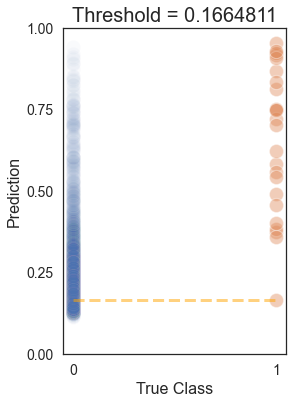

In [886]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

threshold = 0.1664811

plt.figure(figsize=(4,6))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 0], x='true', y='pred', alpha=0.03, s=200)
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 1], x='true', y='pred', alpha=0.4, s=200)
plt.plot([-0, 1], [threshold, threshold], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0])
plt.title('Threshold = {}'.format(threshold), size=20);

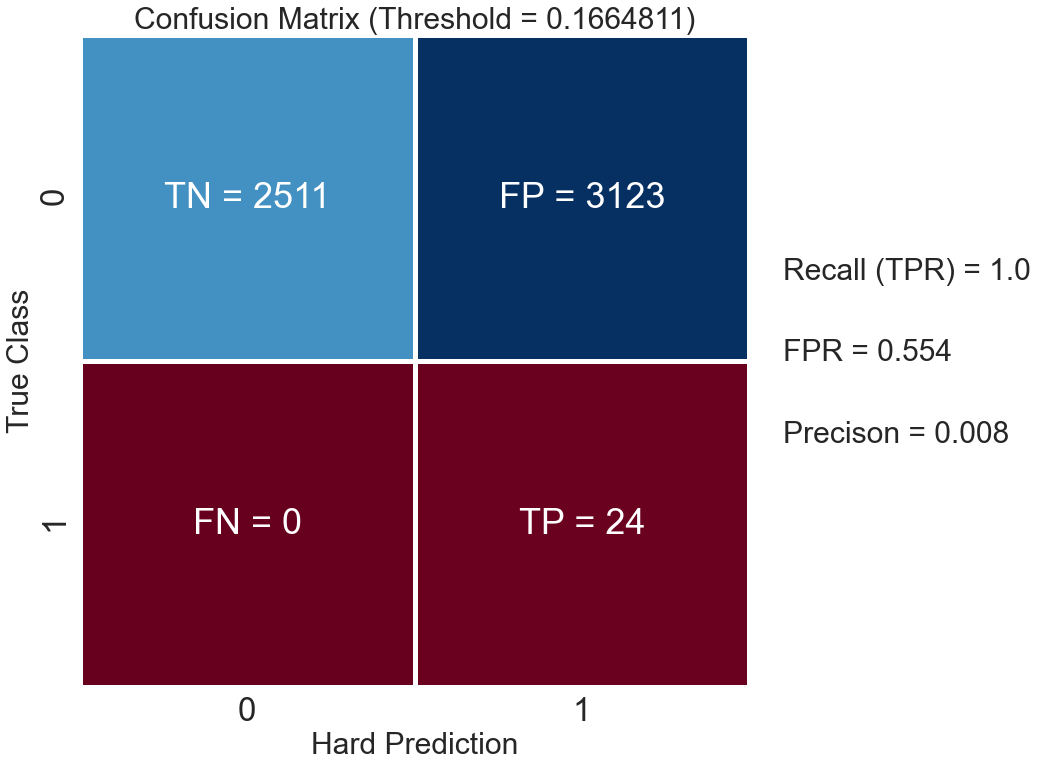

In [887]:
thresh = 0.1664811

preds = df_test_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)

plt.figure(figsize=(12,12))
C = confusion_matrix(df_test_preds['true'], preds)
sns.set(font_scale=3)
sns.set_style('white')

groups = ['TN', 'FP', 'FN', 'TP']
counts = ['{0:0.0f}'.format(val) for val in C.flatten()]
labels = [f'{v1} = {v2}' for v1, v2 in zip(groups, counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(data=C, annot=labels, cmap='RdBu', linewidths=5, fmt='', cbar=False)
plt.ylabel('True Class', size=30)
plt.xlabel('Hard Prediction', size=30)
plt.title('Confusion Matrix (Threshold = {})'.format(thresh), size=30)
plt.text(2.1, 0.75, 'Recall (TPR) = {}'.format(round(recall_score(df_test_preds['true'], preds), 3)), 
         size=30)
plt.text(2.1, 1, 'FPR = {}'.format(round(C[0][1]/C[0].sum(), 3)), 
         size=30)
plt.text(2.1, 1.25, 'Precison = {}'.format(round(precision_score(df_test_preds['true'], preds), 3)),
         size=30);

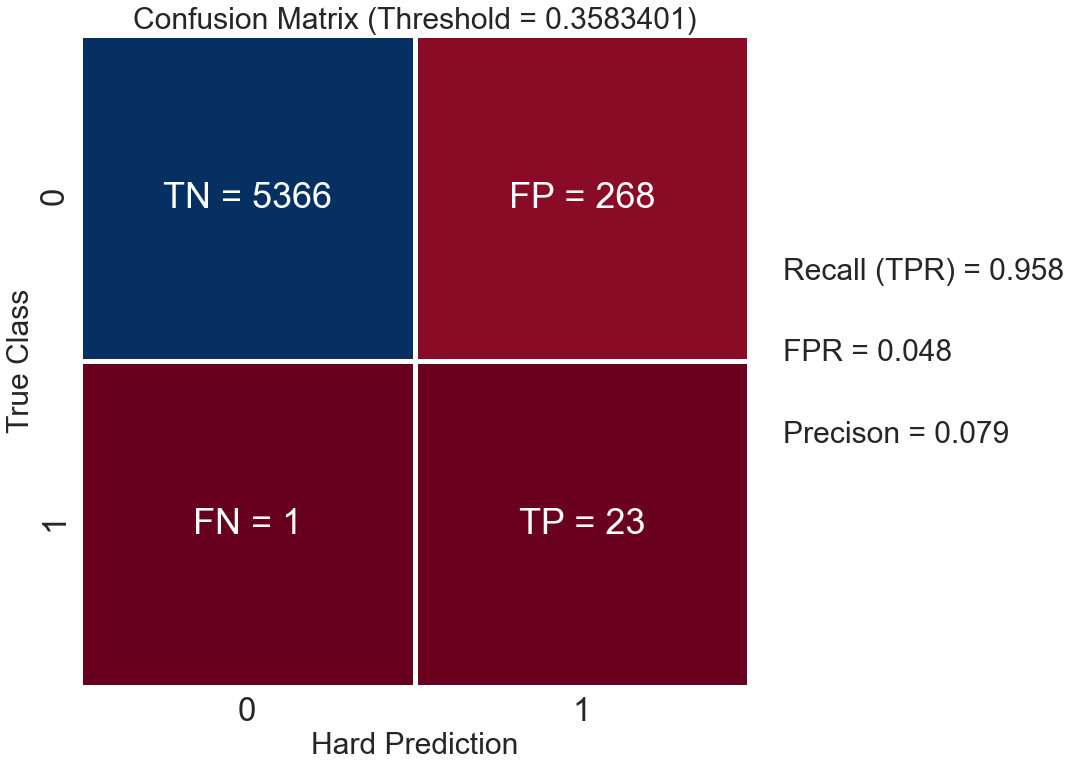

In [888]:
thresh = 0.3583401

preds = df_test_preds['pred'].apply(lambda x: 1 if x >= thresh else 0)

plt.figure(figsize=(12,12))
C = confusion_matrix(df_test_preds['true'], preds)
sns.set(font_scale=3)
sns.set_style('white')

groups = ['TN', 'FP', 'FN', 'TP']
counts = ['{0:0.0f}'.format(val) for val in C.flatten()]
labels = [f'{v1} = {v2}' for v1, v2 in zip(groups, counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(data=C, annot=labels, cmap='RdBu', linewidths=5, fmt='', cbar=False)
plt.ylabel('True Class', size=30)
plt.xlabel('Hard Prediction', size=30)
plt.title('Confusion Matrix (Threshold = {})'.format(thresh), size=30)
plt.text(2.1, 0.75, 'Recall (TPR) = {}'.format(round(recall_score(df_test_preds['true'], preds), 3)), 
         size=30)
plt.text(2.1, 1, 'FPR = {}'.format(round(C[0][1]/C[0].sum(), 3)), 
         size=30)
plt.text(2.1, 1.25, 'Precison = {}'.format(round(precision_score(df_test_preds['true'], preds), 3)),
         size=30);

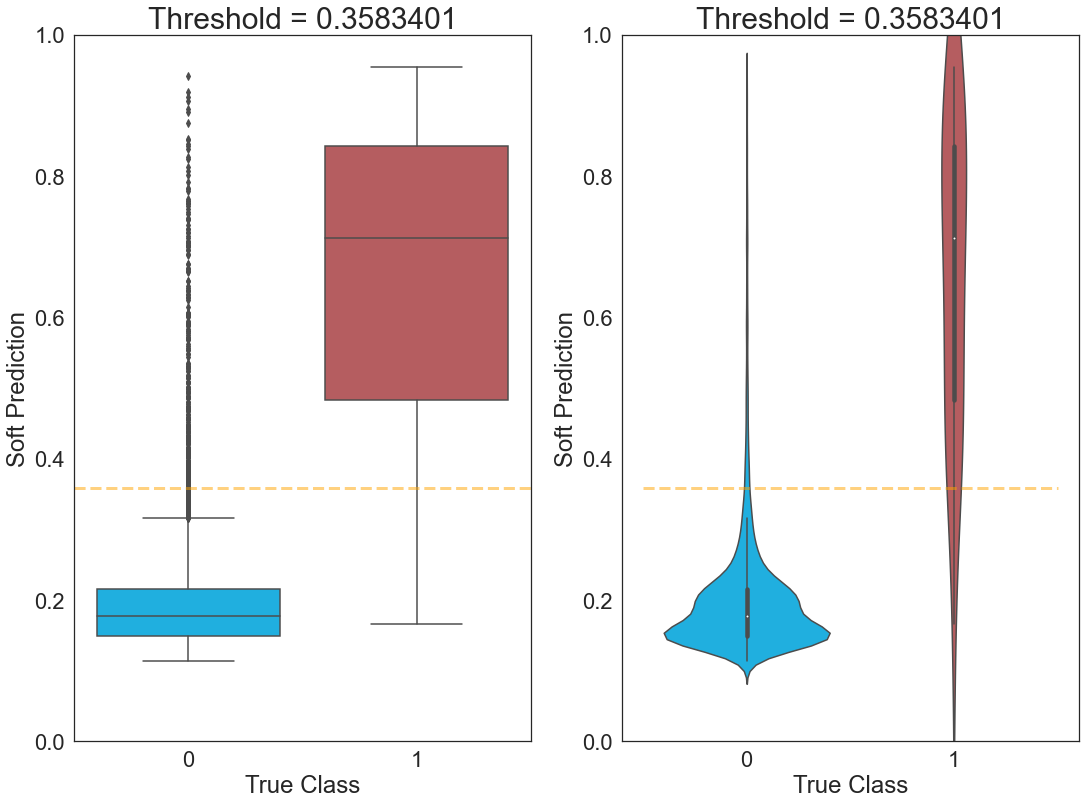

In [889]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

threshold = 0.3583401

plt.figure(figsize=(18,13))
plt.subplot(1, 2, 1)
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.boxplot(data=df_test_preds, x='true', y='pred', palette=my_pal)
plt.plot([-0.5, 1.5], [threshold, threshold], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=24)
plt.ylabel('Soft Prediction', size=24)
plt.xticks(size=22)
plt.yticks(size=22)
plt.ylim([0.0, 1.0])
plt.title('Threshold = {}'.format(threshold), size=30)

plt.subplot(1, 2, 2)
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.violinplot(data=df_test_preds, x='true', y='pred', palette=my_pal)
plt.plot([-0.5, 1.5], [threshold, threshold], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=24)
plt.ylabel('Soft Prediction', size=24)
plt.xticks(size=22)
plt.yticks(size=22)
plt.ylim([0.0, 1.0])
plt.title('Threshold = {}'.format(threshold), size=30);

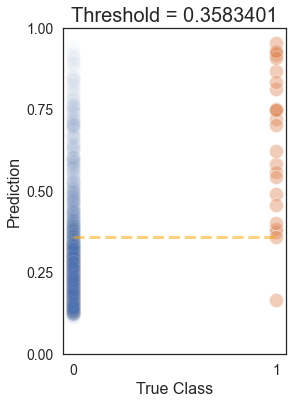

In [890]:
my_pal = {true: "r" if true == 1 else "deepskyblue" for true in df_test_preds['true'].unique()}

threshold = 0.3583401

plt.figure(figsize=(4,6))
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 0], x='true', y='pred', alpha=0.03, s=200)
sns.scatterplot(data=df_test_preds[df_test_preds['true'] == 1], x='true', y='pred', alpha=0.4, s=200)
plt.plot([-0, 1], [threshold, threshold], 
         linestyle='--', c='orange', linewidth=3, alpha=0.5)
plt.xlabel('True Class', size=16)
plt.ylabel('Prediction', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.0])
plt.title('Threshold = {}'.format(threshold), size=20);

### Feature Importance
Voting classifiers do not offer this out-of-the-box, and things are further complicated by the fact that the final model chosen mixes LogisticRegression (which has no built-in feature importance and only uses 69 variables) with XGBoost (which does have feature importance but uses 71 variables). Thus, the function below uses permutation importance of the 71 variables considering the overall voting classifier. The function defined below is based on this article: https://machinelearningmastery.com/calculate-feature-importance-with-python/

In [725]:
def vc_feature_importance(vc_model, X, y, scoring='neg_mean_squared_error'):
    return permutation_importance(vc_model, X, y, scoring=scoring).importances_mean

In [739]:
feature_importances = vc_feature_importance(vc_final2, X_test, y_test['mort30'])

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

In [740]:
feature_importances = sorted(list(zip(X_test.columns.tolist(), feature_importances.tolist())),
                             key = lambda x: x[1],
                             reverse=True)

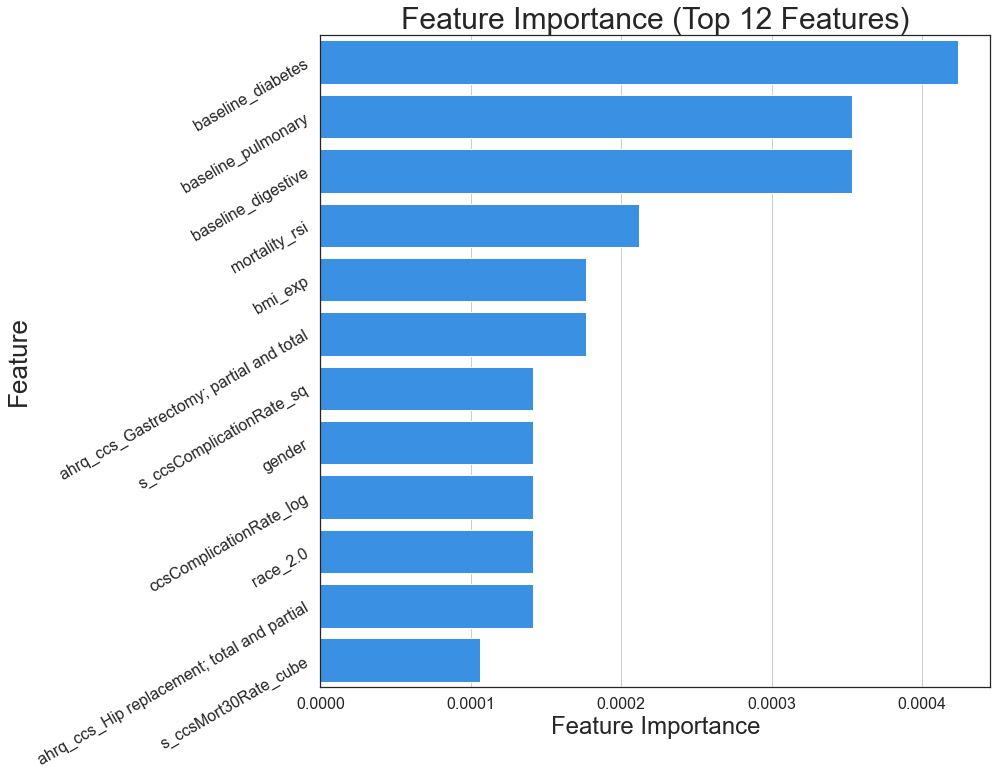

In [772]:
plt.figure(figsize=(12, 12))
x_vals = [val[1] for val in feature_importances if val[1] > 0.0001][0:12]
y_vals = [val[0] for val in feature_importances if val[1] > 0.0001][0:12]
sns.barplot(x=x_vals, y=y_vals, color='dodgerblue')
plt.xlabel('Feature Importance', size=24)
plt.ylabel('Feature', size=26)
plt.xticks(size=16)
plt.yticks(rotation=30, size=16)
plt.grid(axis='x')
plt.title('Feature Importance (Top 12 Features)', size=30)
plt.show()

### What about for the underlying models in the voting classifier?

In [825]:
lr_coeff_magnitudes = sorted(list(zip(X_test.columns[71:].tolist(), 
                                      vc_final2.estimators_[0][1][1].coef_[0].tolist())),
                             key = lambda x: np.abs(x[1]),
                             reverse=True)

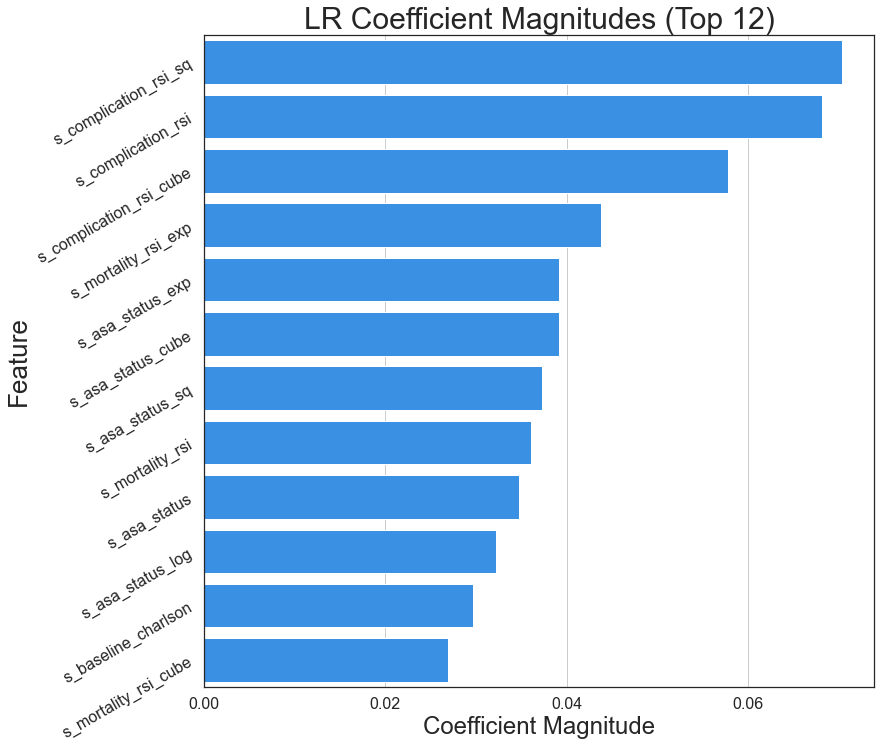

In [826]:
plt.figure(figsize=(12, 12))
x_vals = [val[1] for val in lr_coeff_magnitudes if val[1] > 0.0001][0:12]
y_vals = [val[0] for val in lr_coeff_magnitudes if val[1] > 0.0001][0:12]
sns.barplot(x=x_vals, y=y_vals, color='dodgerblue')
plt.xlabel('Coefficient Magnitude', size=24)
plt.ylabel('Feature', size=26)
plt.xticks(size=16)
plt.yticks(rotation=30, size=16)
plt.grid(axis='x')
plt.title('LR Coefficient Magnitudes (Top 12)', size=30)
plt.show()

In [833]:
xgb_feat_importance = sorted(list(zip(X_test.columns[0:71].tolist(), 
                                      vc_final2.estimators_[1][1][1].feature_importances_.tolist())),
                             key = lambda x: np.abs(x[1]),
                             reverse=True)

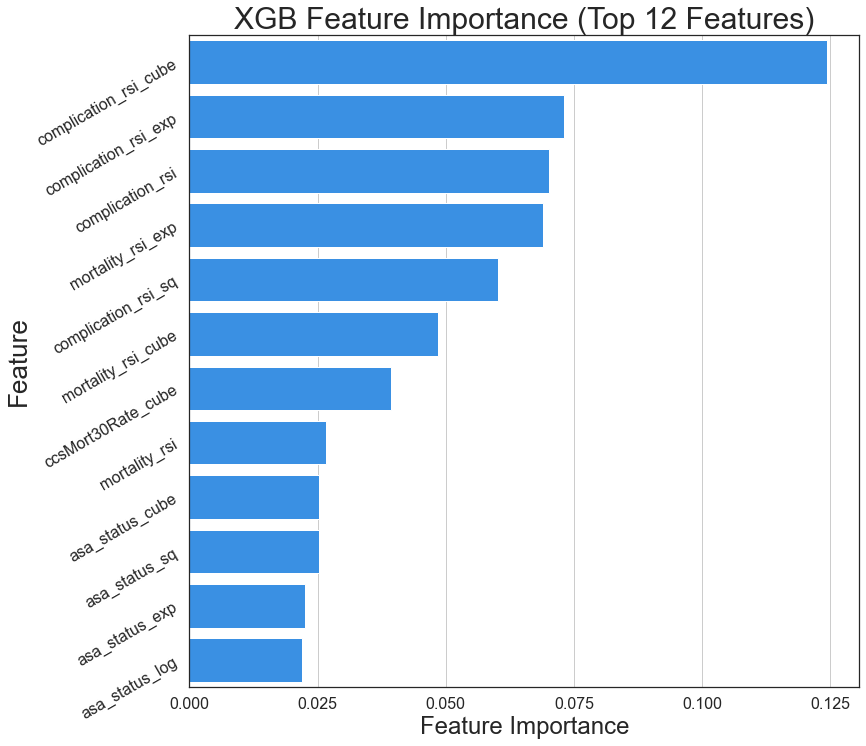

In [834]:
plt.figure(figsize=(12, 12))
x_vals = [val[1] for val in xgb_feat_importance if val[1] > 0.0001][0:12]
y_vals = [val[0] for val in xgb_feat_importance if val[1] > 0.0001][0:12]
sns.barplot(x=x_vals, y=y_vals, color='dodgerblue')
plt.xlabel('Feature Importance', size=24)
plt.ylabel('Feature', size=26)
plt.xticks(size=16)
plt.yticks(rotation=30, size=16)
plt.grid(axis='x')
plt.title('XGB Feature Importance (Top 12 Features)', size=30)
plt.show()

## Conclusion: This last model (ensembling LR & XGB, AUC-optimized) is the best

#### That conclusion is based on the belief that TPR (Recall) = 1.0 is unrealistic due to the high FPR rate of all models (> 0.5)
#### Thus, we set the minimum acceptable TPR to the next lowest achievable level: TPR >= 0.95
#### For TPR = 0.958, this ensembled model only has FPR = 0.048
#### Compare this to the LR model from this ensemble (considered by iteself): TPR = 0.958 with FPR = 0.074
#### Also compare this to the XBG model from this enseble (considered by itself): TPR = 0.958 with FPR = 0.105
#### Also compare this to Ensemble of LR, RF & XGB (AUC optimized): TPR = 0.958 with FPR = 0.065
#### Also compare this to the "kitchen sink" Ensemble of 6 models: TPR = 0.958 with FPR = 0.063